# Best time for holiday
Eemärk analüüsida meteo.physic.ut.ee arhiivi andmeid ja leid parima ilmaga aeg puhkuse jaoks. 
Ette antaks puhkuse pikkus päevades. Programm leiab kalendrist ajad, mil sellise perioodi kestel on ajalooliselt olnud kõrgeim keskmine temperatuur, vähim sademeid jne. Võrrelda saaks nii ajaloolist keskmist, kui ka kõiki varasemaid aastaid eraldi.
<hr>
The aim is to find warmest and dryest time for holiday through analyseing historical weather data. Project is built on data from Tartu University wether station (http://meteo.physic.ut.ee) but also other data sources can be used.
<br>
The length of holiday must be defined (number of days).

You can start from here if you would like to skip data acq. and first prep <br>
[Another Cell](#parttime1)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as datetime
import seaborn as sns
import os
import psutil
import numpy as np

pd.__version__

'0.25.3'


Data can be acquired from here: http://meteo.physic.ut.ee/en/archive.php?do=data&begin%5Byear%5D=2018&begin%5Bmon%5D=9&begin%5Bmday%5D=1&end%5Byear%5D=2018&end%5Bmon%5D=9&end%5Bmday%5D=14&9=1&12=1&10=1&15=1&16=1&17=1&11=1&14=1&13=1&snow_16=1&ok=+Query+

It seems that meteo server is not acepting longer periods than 12 months. Step-by-step query is needed.



# Getting data 

In [2]:
# get current date and time
moment=datetime.datetime.now()
print('moment: ',moment)

#and take one day from now
endtime=moment+datetime.timedelta(days=1)
print('endtime:',endtime)

moment:  2021-01-17 18:03:30.812799
endtime: 2021-01-18 18:03:30.812799


In [3]:
%%time
# testing if there is a local data cache file availabele
# and reading it
# get the latest timepoint from the file
# if there is no local cache available, set the starttime to 1999-1-1

#import os
failinimed=os.listdir()
if 'datacache.pkl' not in failinimed:
    starttime=datetime.datetime(1999, 1,1)
    data=pd.DataFrame()
else:
    data=pd.read_pickle('datacache.pkl', compression='gzip')
    starttime=data.index[-1]

print('Data points: \n', data.count())
print('---')
print('Last datapoint:', starttime)
print('---')

writeneeded=False

Data points: 
  Temperature          2194797
 Humidity             2194797
 Air pressure         2194797
 Wind speed           2194797
 Wind direction       2194797
 Precipitation        2194797
 UV index             2194797
 Light                2194797
 Irradiation flux     2194797
 Gamma radiation      2194797
 Snowfall estimate    2194797
dtype: int64
---
Last datapoint: 2021-01-17 10:20:00
---
CPU times: user 4.76 s, sys: 1.55 s, total: 6.31 s
Wall time: 7.52 s


In [4]:
%%time
# Meteo server is not accepting querys for much longer period than one year. So we get the data by fragments...

def meteoquery(strt,endt):
    print('Getting:', strt, '->', endt)
    url='http://meteo.physic.ut.ee/en/archive.php?do=data&begin%5Byear%5D={0}&begin%5Bmon%5D={1}&begin%5Bmday%5D={2}&end%5Byear%5D={3}&end%5Bmon%5D={4}&end%5Bmday%5D={5}&9=1&12=1&10=1&15=1&16=1&17=1&11=1&14=1&13=1&snow_16=1&ok=+Query+'.format(strt.year, strt.month, strt.day, endt.year, endt.month, endt.day)
#    print(url)
    result=pd.read_csv(url,parse_dates=['Times'], index_col='Times', engine='python')
    return result


moment=datetime.datetime.now()
while starttime+datetime.timedelta(days=360)<moment:
    endtime=starttime+datetime.timedelta(days=360)
    data=pd.concat([data, meteoquery(starttime, endtime)]).drop_duplicates()
    writeneeded=True
    starttime=endtime
if ((moment-starttime).total_seconds()/(60*60)) > 2: #no new querys to the server if last measurement is newer than # hours.
    if moment.month==12 and moment.day==31: #on the last day of the year, othrways the query to the server fails - you cant get weather data for the 31.dec on 31.dec
        endtime=moment+datetime.timedelta(days=0)
    else:
        endtime=moment+datetime.timedelta(days=1)
    data=pd.concat([data, meteoquery(starttime, endtime)]).drop_duplicates()
    writeneeded=True

Getting: 2021-01-17 10:20:00 -> 2021-01-18 18:03:44.726780
CPU times: user 11.6 s, sys: 1.39 s, total: 13 s
Wall time: 13.4 s


Originally toke 5min 49s @ 10 Mbps to download raw data from Meteo server

In [5]:
%%time
# writing data to local cache file datacache.pkl
if writeneeded:
    data.to_pickle('datacache.pkl', compression='gzip')
    writeneeded=False

CPU times: user 53.2 s, sys: 867 ms, total: 54.1 s
Wall time: 56.3 s


1min 15s sec to save it to the pickle file compressed with gzip
<br>file size is 65.7 MB compressed. 66 MB on 4. oct. 2018. 71.6 MB on 21. march 2019. 70 MB on 30. april 2019. 80 MB on january 2021.
<br> with MacBookAir late 2011 1min 17s
<br> with MacBook pro mid 2014 52.8 s

# Inspecting data

In [6]:
data.info()
print('---')
print('Datapoints: ', len(data))
print('First datapoint:', data.index[0])
print('Last datapoint: ', data.index[-1])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2194888 entries, 1999-11-01 00:00:00 to 2021-01-17 17:55:00
Data columns (total 11 columns):
 Temperature          object
 Humidity             object
 Air pressure         object
 Wind speed           object
 Wind direction       object
 Precipitation        object
 UV index             object
 Light                object
 Irradiation flux     object
 Gamma radiation      object
 Snowfall estimate    object
dtypes: object(11)
memory usage: 200.9+ MB
---
Datapoints:  2194888
First datapoint: 1999-11-01 00:00:00
Last datapoint:  2021-01-17 17:55:00


# Correcting dataframe structure

In [7]:
data.columns.tolist()

[' Temperature',
 ' Humidity',
 ' Air pressure',
 ' Wind speed',
 ' Wind direction',
 ' Precipitation',
 ' UV index',
 ' Light',
 ' Irradiation flux',
 ' Gamma radiation',
 ' Snowfall estimate']

In [8]:
#removing unnessesary spaces fron column names
data.columns=data.columns.str.strip().str.replace(' ','_')
data.columns.tolist()

['Temperature',
 'Humidity',
 'Air_pressure',
 'Wind_speed',
 'Wind_direction',
 'Precipitation',
 'UV_index',
 'Light',
 'Irradiation_flux',
 'Gamma_radiation',
 'Snowfall_estimate']

In [9]:
pd.concat([data.head(),data.tail()])

,Temperature,Humidity,Air_pressure,Wind_speed,Wind_direction,Precipitation,UV_index,Light,Irradiation_flux,Gamma_radiation,Snowfall_estimate
Times,,,,,,,,,,,
1999-11-01 00:00:00,6.6,,1001.7,1.1,227,,,0,,0.092,
1999-11-01 00:05:00,6.6,,1001.5,1.2,230,,,0,,0.09,
1999-11-01 00:10:00,6.5,,1001.2,0.5,203,,,0,,0.103,
1999-11-01 00:15:00,6.6,,1001.6,0.8,223,,,0,,0.063,
1999-11-01 00:20:00,6.6,,1001.7,1.3,243,,,0,,0.101,
2021-01-17 17:35:00,-10.2348,88.7064,1017.93,4.5705,276.459,0,,,7.10075,,0
2021-01-17 17:40:00,-10.2259,88.7004,1017.98,3.66048,274.978,0,,,8.262,,0
2021-01-17 17:45:00,-10.218,88.7046,1018.03,4.55813,274.551,0,,,7.40665,,0
2021-01-17 17:50:00,-10.1939,88.7505,1018.07,4.16692,274.926,0,,,8.82809,,0


Changeing data types to float

In [10]:
%%time
for element in data.columns:
    print(element)
    data[element]=pd.to_numeric(data[element],errors='coerce')

Temperature
Humidity
Air_pressure
Wind_speed
Wind_direction
Precipitation
UV_index
Light
Irradiation_flux
Gamma_radiation
Snowfall_estimate
CPU times: user 15.7 s, sys: 941 ms, total: 16.6 s
Wall time: 15.3 s


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2194888 entries, 1999-11-01 00:00:00 to 2021-01-17 17:55:00
Data columns (total 11 columns):
Temperature          float64
Humidity             float64
Air_pressure         float64
Wind_speed           float64
Wind_direction       float64
Precipitation        float64
UV_index             float64
Light                float64
Irradiation_flux     float64
Gamma_radiation      float64
Snowfall_estimate    float64
dtypes: float64(11)
memory usage: 200.9 MB


In [12]:
pd.concat([data.head(), data.tail()])

,Temperature,Humidity,Air_pressure,Wind_speed,Wind_direction,Precipitation,UV_index,Light,Irradiation_flux,Gamma_radiation,Snowfall_estimate
Times,,,,,,,,,,,
1999-11-01 00:00:00,6.600000,NaN,1001.700000,1.100000,227.000000,NaN,NaN,0.0,NaN,0.092,NaN
1999-11-01 00:05:00,6.600000,NaN,1001.500000,1.200000,230.000000,NaN,NaN,0.0,NaN,0.090,NaN
1999-11-01 00:10:00,6.500000,NaN,1001.200000,0.500000,203.000000,NaN,NaN,0.0,NaN,0.103,NaN
1999-11-01 00:15:00,6.600000,NaN,1001.600000,0.800000,223.000000,NaN,NaN,0.0,NaN,0.063,NaN
1999-11-01 00:20:00,6.600000,NaN,1001.700000,1.300000,243.000000,NaN,NaN,0.0,NaN,0.101,NaN
2021-01-17 17:35:00,-10.234814,88.706389,1017.930300,4.570504,276.459155,0.0,NaN,NaN,7.100746,NaN,0.0
2021-01-17 17:40:00,-10.225908,88.700438,1017.977733,3.660477,274.978062,0.0,NaN,NaN,8.262001,NaN,0.0
2021-01-17 17:45:00,-10.217987,88.704639,1018.031167,4.558131,274.551255,0.0,NaN,NaN,7.406648,NaN,0.0
2021-01-17 17:50:00,-10.193917,88.750460,1018.073533,4.166916,274.926104,0.0,NaN,NaN,8.828086,NaN,0.0


In [13]:
data.describe()

,Temperature,Humidity,Air_pressure,Wind_speed,Wind_direction,Precipitation,UV_index,Light,Irradiation_flux,Gamma_radiation,Snowfall_estimate
count,2.190500e+06,2.011752e+06,2.136106e+06,1.768799e+06,1.713655e+06,1.923232e+06,288481.000000,1.374432e+06,1.264623e+06,1.509583e+06,1.919174e+06
mean,6.676796e+00,7.819979e+01,1.008059e+03,2.763674e+00,1.921973e+02,4.175011e-03,1.533479,9.517597e+03,1.183181e+02,9.808723e-02,4.081235e-03
std,9.373448e+00,1.939065e+01,1.146232e+01,1.779950e+00,9.014253e+01,4.749794e-02,4.398442,1.963957e+04,2.180060e+02,1.672303e-02,1.035580e-01
min,-1.318409e+02,-1.583138e+00,8.115000e+02,0.000000e+00,0.000000e+00,-8.400000e+00,0.000064,-2.962994e+04,-4.366599e+01,-3.288218e-02,-6.800000e+00
25%,2.012925e-01,6.606990e+01,1.001020e+03,1.500000e+00,1.245676e+02,0.000000e+00,0.134925,4.380000e+02,1.677905e+00,8.771386e-02,0.000000e+00
50%,6.230358e+00,8.350000e+01,1.008200e+03,2.555480e+00,2.058329e+02,0.000000e+00,0.627143,1.965451e+03,5.386745e+00,9.671618e-02,0.000000e+00
75%,1.403702e+01,9.389845e+01,1.015380e+03,3.787134e+00,2.670000e+02,0.000000e+00,1.519061,8.681000e+03,1.250000e+02,1.070000e-01,0.000000e+00
max,3.370000e+01,1.209572e+02,1.054122e+03,5.105643e+01,3.600000e+02,9.799000e+00,54.125747,3.747921e+05,1.998000e+03,2.440000e-01,1.930000e+01


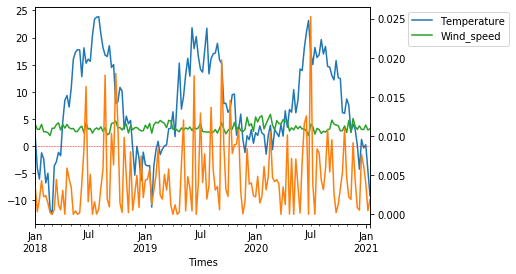

In [14]:
ax=data['2018':][['Temperature','Precipitation','Wind_speed']].resample('W').mean().plot(secondary_y=['Precipitation']);
ax.legend(loc='upper left', bbox_to_anchor=(1.1,1));
#ax=data['2018-10-3']['Temperature'].plot()
#data['2018-10-3']['Precipitation'].dropna().plot(secondary_y='Precipitation', ax=ax)
ax.axhline(y=0, color='r', linestyle='--', linewidth=0.5);

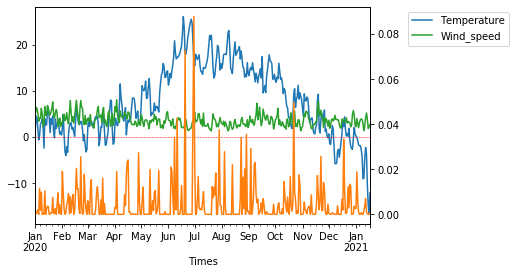

In [15]:
ax=data['2020-1':][['Temperature','Precipitation','Wind_speed']].resample('D').mean().plot(secondary_y=['Precipitation']);
ax.legend(loc='upper left', bbox_to_anchor=(1.1,1));
#ax=data['2018-10-3']['Temperature'].plot()
#data['2018-10-3']['Precipitation'].dropna().plot(secondary_y='Precipitation', ax=ax)
ax.axhline(y=0, color='r', linestyle='--', linewidth=0.5);

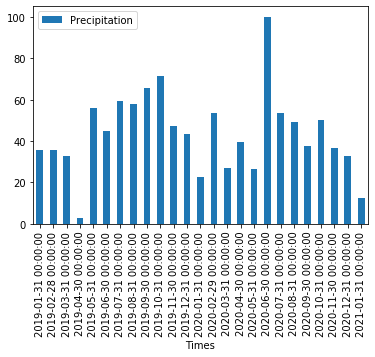

In [16]:
data['2019-01':][['Precipitation']].resample('1M').sum().plot.bar()

In [17]:
%%time
# Save preprocessed data to file
data.to_pickle("data.pkl")

CPU times: user 158 ms, sys: 287 ms, total: 445 ms
Wall time: 717 ms


<a id='parttime1'></a>
<hr>

## ---- Work can be continued from here ------
Reading preprocessed data from file data.pkl


In [30]:
#Prerequisits (needed if started from this point)
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as datetime
import seaborn as sns
import os
import psutil
import numpy as np

In [170]:
%%time
data=pd.read_pickle("data.pkl")
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2155121 entries, 1999-11-01 00:00:00 to 2020-09-04 11:15:00
Data columns (total 11 columns):
Temperature          float64
Humidity             float64
Air_pressure         float64
Wind_speed           float64
Wind_direction       float64
Precipitation        float64
UV_index             float64
Light                float64
Irradiation_flux     float64
Gamma_radiation      float64
Snowfall_estimate    float64
dtypes: float64(11)
memory usage: 197.3 MB
CPU times: user 129 ms, sys: 325 ms, total: 455 ms
Wall time: 749 ms


# Data cleaning
Cleaning up nonsens data

In [18]:
data.describe()

,Temperature,Humidity,Air_pressure,Wind_speed,Wind_direction,Precipitation,UV_index,Light,Irradiation_flux,Gamma_radiation,Snowfall_estimate
count,2.190500e+06,2.011752e+06,2.136106e+06,1.768799e+06,1.713655e+06,1.923232e+06,288481.000000,1.374432e+06,1.264623e+06,1.509583e+06,1.919174e+06
mean,6.676796e+00,7.819979e+01,1.008059e+03,2.763674e+00,1.921973e+02,4.175011e-03,1.533479,9.517597e+03,1.183181e+02,9.808723e-02,4.081235e-03
std,9.373448e+00,1.939065e+01,1.146232e+01,1.779950e+00,9.014253e+01,4.749794e-02,4.398442,1.963957e+04,2.180060e+02,1.672303e-02,1.035580e-01
min,-1.318409e+02,-1.583138e+00,8.115000e+02,0.000000e+00,0.000000e+00,-8.400000e+00,0.000064,-2.962994e+04,-4.366599e+01,-3.288218e-02,-6.800000e+00
25%,2.012925e-01,6.606990e+01,1.001020e+03,1.500000e+00,1.245676e+02,0.000000e+00,0.134925,4.380000e+02,1.677905e+00,8.771386e-02,0.000000e+00
50%,6.230358e+00,8.350000e+01,1.008200e+03,2.555480e+00,2.058329e+02,0.000000e+00,0.627143,1.965451e+03,5.386745e+00,9.671618e-02,0.000000e+00
75%,1.403702e+01,9.389845e+01,1.015380e+03,3.787134e+00,2.670000e+02,0.000000e+00,1.519061,8.681000e+03,1.250000e+02,1.070000e-01,0.000000e+00
max,3.370000e+01,1.209572e+02,1.054122e+03,5.105643e+01,3.600000e+02,9.799000e+00,54.125747,3.747921e+05,1.998000e+03,2.440000e-01,1.930000e+01


In [19]:
data.columns.tolist()

['Temperature',
 'Humidity',
 'Air_pressure',
 'Wind_speed',
 'Wind_direction',
 'Precipitation',
 'UV_index',
 'Light',
 'Irradiation_flux',
 'Gamma_radiation',
 'Snowfall_estimate']

In [20]:
# just for nicer plots
distmax={'Temperature':0.05,
 'Humidity':0.05,
 'Air_pressure':0.04,
 'Wind_speed':0.25,
 'Wind_direction':0.005,
 'Precipitation':3,
 'UV_index':0.6,
 'Light':0.0002,
 'Irradiation_flux':0.035,
 'Gamma_radiation':25,
 'Snowfall_estimate':5}


# Set numeric format to more easily readable
pd.options.display.float_format = '{:.4f}'.format

Temperature :
count   2190500.0000
mean          6.6768
std           9.3734
min        -131.8409
25%           0.2013
50%           6.2304
75%          14.0370
max          33.7000
Name: Temperature, dtype: float64


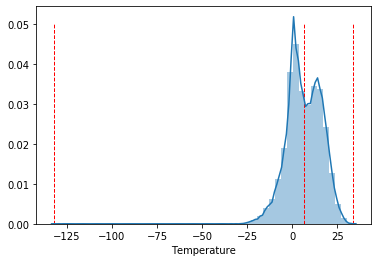

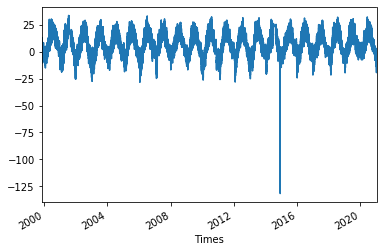

___________
Humidity :
count   2011752.0000
mean         78.1998
std          19.3906
min          -1.5831
25%          66.0699
50%          83.5000
75%          93.8985
max         120.9572
Name: Humidity, dtype: float64


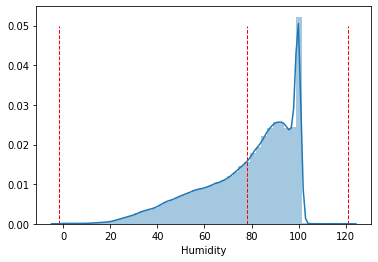

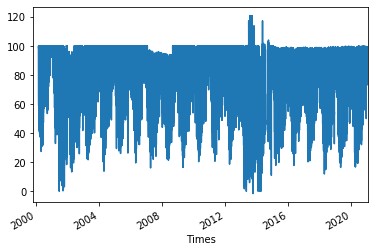

___________
Air_pressure :
count   2136106.0000
mean       1008.0586
std          11.4623
min         811.5000
25%        1001.0199
50%        1008.2000
75%        1015.3796
max        1054.1222
Name: Air_pressure, dtype: float64


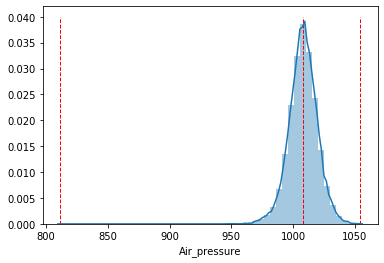

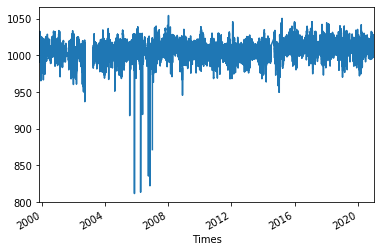

___________
Wind_speed :
count   1768799.0000
mean          2.7637
std           1.7800
min           0.0000
25%           1.5000
50%           2.5555
75%           3.7871
max          51.0564
Name: Wind_speed, dtype: float64


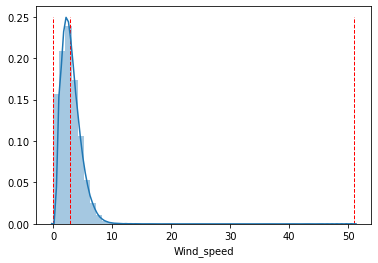

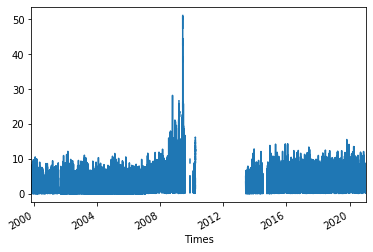

___________
Wind_direction :
count   1713655.0000
mean        192.1973
std          90.1425
min           0.0000
25%         124.5676
50%         205.8329
75%         267.0000
max         360.0000
Name: Wind_direction, dtype: float64


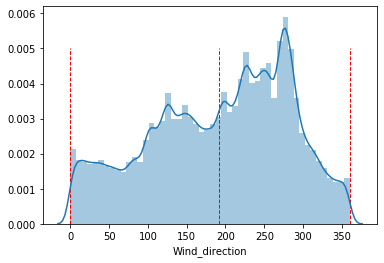

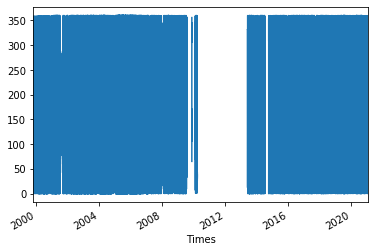

___________
Precipitation :
count   1923232.0000
mean          0.0042
std           0.0475
min          -8.4000
25%           0.0000
50%           0.0000
75%           0.0000
max           9.7990
Name: Precipitation, dtype: float64


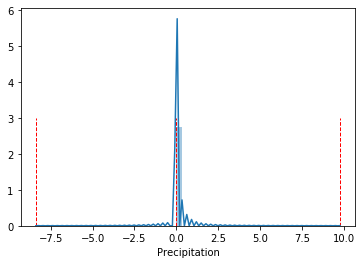

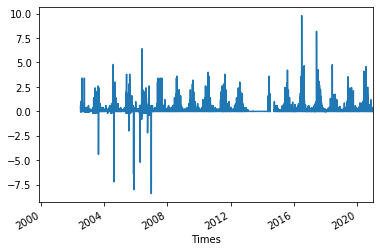

___________
UV_index :
count   288481.0000
mean         1.5335
std          4.3984
min          0.0001
25%          0.1349
50%          0.6271
75%          1.5191
max         54.1257
Name: UV_index, dtype: float64


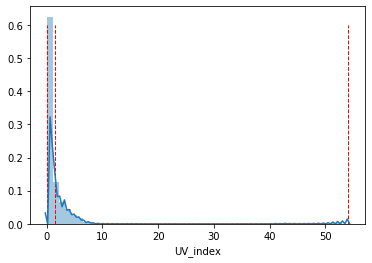

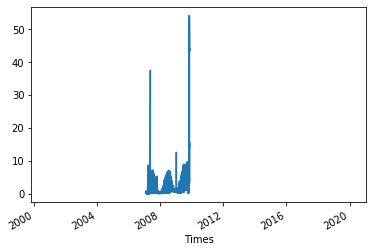

___________
Light :
count   1374432.0000
mean       9517.5968
std       19639.5699
min      -29629.9438
25%         438.0000
50%        1965.4513
75%        8681.0000
max      374792.0898
Name: Light, dtype: float64


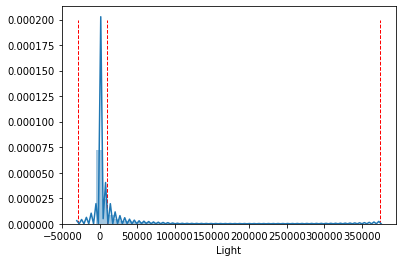

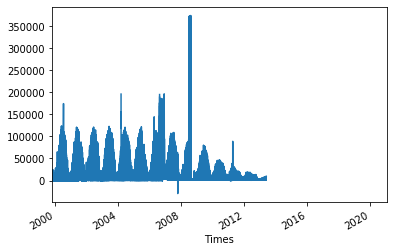

___________
Irradiation_flux :
count   1264623.0000
mean        118.3181
std         218.0060
min         -43.6660
25%           1.6779
50%           5.3867
75%         125.0000
max        1998.0000
Name: Irradiation_flux, dtype: float64


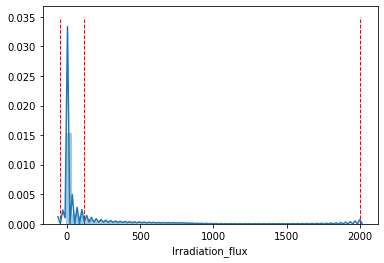

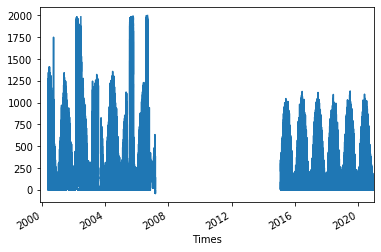

___________
Gamma_radiation :
count   1509583.0000
mean          0.0981
std           0.0167
min          -0.0329
25%           0.0877
50%           0.0967
75%           0.1070
max           0.2440
Name: Gamma_radiation, dtype: float64


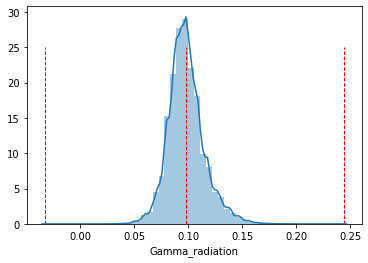

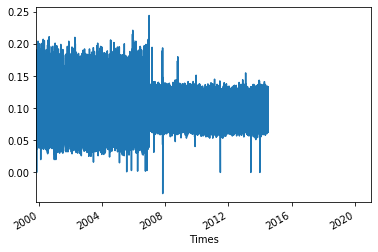

___________
Snowfall_estimate :
count   1919174.0000
mean          0.0041
std           0.1036
min          -6.8000
25%           0.0000
50%           0.0000
75%           0.0000
max          19.3000
Name: Snowfall_estimate, dtype: float64


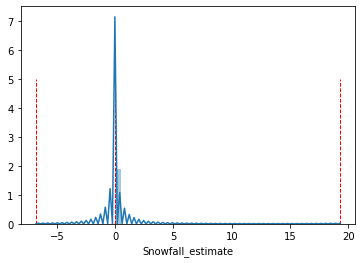

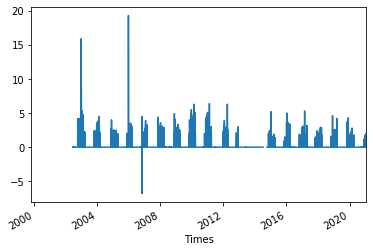

___________


In [21]:
for element in data.columns:
#    print(element, 'min:', data[element].min(), 'max:', data[element].max())
    print(element,':')
    print(data[element].describe())
    ax=sns.distplot(data[element].dropna());
    ax.vlines([data[element].min(), data[element].max(), data[element].mean()], 0, distmax[element],linewidth=1, linestyle='--', color='red')
    plt.show()
    data[element].plot()
    plt.show()
    print('___________')

### Conclusions from data quality investigation
1. Temperatures (in Celsius) below -40 in year 2014 december is not realistic
***
2. Humidity (RH) over 100% and below 0% in not realistic. Even 0% seems to be unrealistic.
3. Air pressure is in [hPa]. Below 940 seems to be unrealistic!
4. Wind speed over 30 m/s seems to be unrealistic!
5. Wind direction seems to be OK; just we dont need more precision than 10 deg.
6. Precipitation below 0 is not real
7. UV index over 10, is it realistic? Probably not!
8. Light below 0 is not real. Also investigate the upper limit - over 350000, is it realistic? Proably not. Realistic maximum seems to be below 140000.
9. Irradiation_flux below 0 is not real? Over 1400 seems to be also suspicious. 
10. Gamma_radiation find out realistic values. Below 0 is not real - one reading. Is upper limit OK? 0.244
11. Snowfall_estimate below 0 and over 10, is it realistic? Two readings over 8.7 and 

### Temperatures

In [22]:
# Set numeric format to more easily readable
pd.options.display.float_format = '{:.4f}'.format

In [23]:
data.Temperature.describe()

count   2190500.0000
mean          6.6768
std           9.3734
min        -131.8409
25%           0.2013
50%           6.2304
75%          14.0370
max          33.7000
Name: Temperature, dtype: float64

min: -131.840910289 max: 33.7


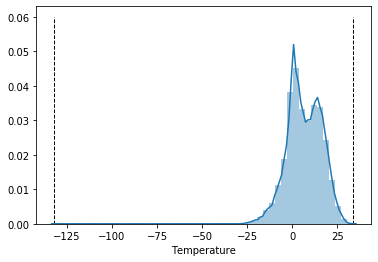

In [24]:
ax=sns.distplot(data.Temperature.dropna())
ax.vlines([data.Temperature.min(), data.Temperature.max()], 0, 0.06,linewidth=1, linestyle='--')
print('min:',data.Temperature.min(), 'max:',data.Temperature.max())

In [25]:
data.Temperature.nsmallest(10)

Times
2014-12-12 16:10:00   -131.8409
2014-12-12 16:15:00   -130.0620
2014-12-12 16:25:00    -97.8874
2014-12-12 16:05:00    -85.0415
2014-12-12 16:20:00    -73.8580
2014-12-12 16:30:00    -51.2103
2006-01-20 06:10:00    -28.4000
2006-01-20 06:15:00    -28.4000
2006-01-20 08:15:00    -28.4000
2006-01-20 08:35:00    -28.4000
Name: Temperature, dtype: float64

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2194888 entries, 1999-11-01 00:00:00 to 2021-01-17 17:55:00
Data columns (total 11 columns):
Temperature          float64
Humidity             float64
Air_pressure         float64
Wind_speed           float64
Wind_direction       float64
Precipitation        float64
UV_index             float64
Light                float64
Irradiation_flux     float64
Gamma_radiation      float64
Snowfall_estimate    float64
dtypes: float64(11)
memory usage: 280.9 MB


In [27]:
#dropping urealistic measeurements below -29 degrees Celsius
data.drop(data.loc[data.Temperature<-29].index, inplace=True)

#maybe it's better idea to not drop these lines but replace unrealistic temp values with nan?

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2194882 entries, 1999-11-01 00:00:00 to 2021-01-17 17:55:00
Data columns (total 11 columns):
Temperature          float64
Humidity             float64
Air_pressure         float64
Wind_speed           float64
Wind_direction       float64
Precipitation        float64
UV_index             float64
Light                float64
Irradiation_flux     float64
Gamma_radiation      float64
Snowfall_estimate    float64
dtypes: float64(11)
memory usage: 200.9 MB


In [28]:

data.loc[data.Temperature.isnull()]

,Temperature,Humidity,Air_pressure,Wind_speed,Wind_direction,Precipitation,UV_index,Light,Irradiation_flux,Gamma_radiation,Snowfall_estimate
Times,,,,,,,,,,,
1999-11-24 03:05:00,nan,nan,1018.7000,1.6000,122.0000,nan,nan,0.0000,nan,0.0840,nan
1999-11-24 03:10:00,nan,nan,1018.8000,1.5000,133.0000,nan,nan,0.0000,nan,0.1280,nan
1999-11-24 03:15:00,nan,nan,1018.7000,1.6000,121.0000,nan,nan,0.0000,nan,0.1350,nan
1999-11-24 03:20:00,nan,nan,1019.0000,1.6000,123.0000,nan,nan,0.0000,nan,0.1210,nan
1999-11-24 03:25:00,nan,nan,1018.7000,1.6000,115.0000,nan,nan,0.0000,nan,0.1030,nan
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-29 08:16:18,nan,nan,nan,nan,nan,0.0000,nan,nan,4.3277,nan,nan
2020-12-29 08:16:54,nan,nan,nan,nan,nan,0.0000,nan,nan,4.0413,nan,nan
2020-12-29 08:19:04,nan,nan,nan,nan,nan,0.0000,nan,nan,3.5023,nan,nan


In [29]:
# do I have to drop NaN values?
#data.Temperature.dropna(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2194882 entries, 1999-11-01 00:00:00 to 2021-01-17 17:55:00
Data columns (total 11 columns):
Temperature          float64
Humidity             float64
Air_pressure         float64
Wind_speed           float64
Wind_direction       float64
Precipitation        float64
UV_index             float64
Light                float64
Irradiation_flux     float64
Gamma_radiation      float64
Snowfall_estimate    float64
dtypes: float64(11)
memory usage: 200.9 MB


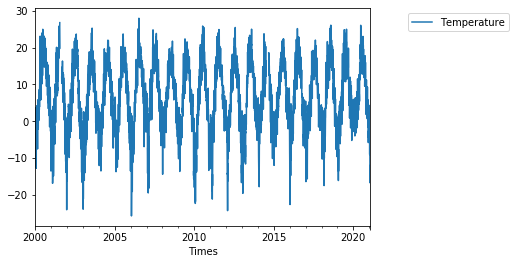

In [30]:
ax=data['2000-1':].Temperature.resample('D').mean().plot()
ax.legend(loc='upper left', bbox_to_anchor=(1.1,1))

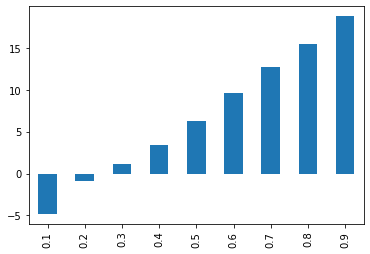

In [31]:
data.Temperature.quantile([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).plot(kind='bar')

min: -28.4 max: 33.7 mean: 6.677074253207857 median: 6.23036727688822 mode: 0   0.0000
dtype: float64


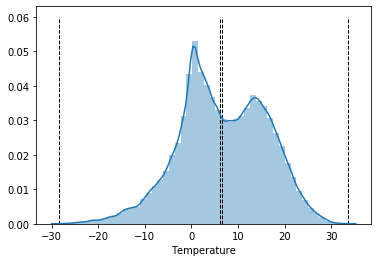

In [32]:
ax=sns.distplot(data.Temperature.dropna())
ax.vlines([data.Temperature.min(), data.Temperature.max(), data.Temperature.mean(), data.Temperature.median()], 0, 0.06, linewidth=1, linestyle='--')
print('min:',data.Temperature.min(), 'max:',data.Temperature.max(),'mean:',data.Temperature.mean(), 'median:',data.Temperature.median(), 'mode:', data.Temperature.mode())

Should we try CDF distribution?
http://stanford.edu/~raejoon/blog/2017/05/16/python-recipes-for-cdfs.html
https://stackoverflow.com/questions/24575869/read-file-and-plot-cdf-in-python


CPU times: user 8min 27s, sys: 10.7 s, total: 8min 38s
Wall time: 8min 40s


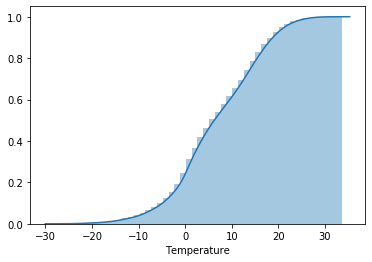

In [36]:
%%time
# You dont have to run this - it takes several minutes!
# sns.distplot(data.Temperature.dropna(),
#             hist_kws=dict(cumulative=True),
#             kde_kws=dict(cumulative=True))

PC1: Core i7 920 4-core/8-threads =6min 34s
<br>PC2: Core i5 4590 4-core/4-threads =5min 46s
<br>MacBookAir late 2011 i5 1.7 GHz 4GB RAM =7min 10s
<br>MacBookPro 2014 =9min 12s (2020.05.28, 2122773 entries)


### Precipitation
/not jet realized/

### Wind direction

In [37]:
# we don't need wind direction data with 0.001 deg precission
data.Wind_direction = data.Wind_direction.round(-1) #-1 or 0

In [38]:
data.Wind_direction.unique()

array([230., 200., 220., 240., 250.,  nan, 210., 190., 180., 170., 260.,
       270., 280., 290., 300., 160., 150., 140., 130., 120., 110., 100.,
        80.,  90.,  70., 310., 320., 330., 340., 350., 360.,  10.,   0.,
        20.,  60.,  50.,  40.,  30.])

min: 0.0 max: 360.0 mean: 192.1919657992973 median: 210.0 mode: 0   280.0000
dtype: float64


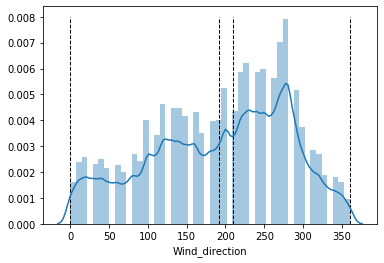

In [39]:
ax=sns.distplot(data.Wind_direction.dropna())
ax.vlines([data.Wind_direction.min(), data.Wind_direction.max(), data.Wind_direction.mean(), data.Wind_direction.median()], 0, 0.008, linewidth=1, linestyle='--')
print('min:',data.Wind_direction.min(), 'max:',data.Wind_direction.max(),'mean:',data.Wind_direction.mean(), 'median:',data.Wind_direction.median(), 'mode:', data.Wind_direction.mode())

# Additional data prep

#import os
#import psutil
process = psutil.Process(os.getpid())
print(process.name(),':',process.memory_info().rss/1024/1024,'MB RAM usage')

data.drop(data.columns[1:], axis=1, inplace=True)
data.info()

In [40]:
process = psutil.Process(os.getpid())
print(process.name(),':',process.memory_info().rss/1024/1024,'MB RAM usage')

python3.7 : 438.953125 MB RAM usage


***

In [41]:
#what if we down-sample data to 1 day?
#data.Temperature.resample('1D').mean()

# and we should add min/max values for Temp, Hum, air_press, Wind_speed, Light, irradiation_flux, gamma_rad,
# max only for Preciption, UV_index, Snowfall

In [42]:
# adding some collumns for daily min/max values. Original column will be replaced by daily average or sum.
data['Temp_min']=data['Temperature']
data['Temp_max']=data['Temperature']

data['Hum_min']=data['Humidity']
data['Hum_max']=data['Humidity']

data['Airp_min']=data['Air_pressure']
data['Airp_max']=data['Air_pressure']

data['Winds_min']=data['Wind_speed']
data['Winds_max']=data['Wind_speed']

data['Light_min']=data['Light']
data['Light_max']=data['Light']

data['Irrad_min']=data['Irradiation_flux']
data['Irrad_max']=data['Irradiation_flux']

data['Gamma_min']=data['Gamma_radiation']
data['Gamma_max']=data['Gamma_radiation']

data['Prec_max']=data['Precipitation']

data['UV_max']=data['UV_index']

data['Snow_max']=data['Snowfall_estimate']

In [43]:
data.columns

Index(['Temperature', 'Humidity', 'Air_pressure', 'Wind_speed',
       'Wind_direction', 'Precipitation', 'UV_index', 'Light',
       'Irradiation_flux', 'Gamma_radiation', 'Snowfall_estimate', 'Temp_min',
       'Temp_max', 'Hum_min', 'Hum_max', 'Airp_min', 'Airp_max', 'Winds_min',
       'Winds_max', 'Light_min', 'Light_max', 'Irrad_min', 'Irrad_max',
       'Gamma_min', 'Gamma_max', 'Prec_max', 'UV_max', 'Snow_max'],
      dtype='object')

In [44]:
data=data.resample('1D').agg({
    'Temperature':'mean', 
    'Temp_min':'min',
    'Temp_max':'max',
    'Humidity':'mean', 
    'Hum_min':'min',
    'Hum_max':'max',
    'Air_pressure':'mean',
    'Airp_min':'min',
    'Airp_max':'max',
    'Wind_speed':'mean',
    'Winds_min':'min',
    'Winds_max':'max',
    'Wind_direction':'mean', #mean is not appropriate. we need something like mode...
    'Precipitation':'sum', 
    'Prec_max':'max',
    'UV_index':'mean',
    'UV_max':'max',
    'Light':'mean',
    'Light_min':'min',
    'Light_max':'max',
    'Irradiation_flux':'mean', 
    'Irrad_min':'min',
    'Irrad_max':'max',
    'Gamma_radiation':'mean', 
    'Gamma_min':'min',
    'Gamma_max':'max',
    'Snowfall_estimate':'sum',
    'Snow_max':'max'})

In [45]:
data.tail()

,Temperature,Temp_min,Temp_max,Humidity,Hum_min,Hum_max,Air_pressure,Airp_min,Airp_max,Wind_speed,...,Light_min,Light_max,Irradiation_flux,Irrad_min,Irrad_max,Gamma_radiation,Gamma_min,Gamma_max,Snowfall_estimate,Snow_max
Times,,,,,,,,,,,,,,,,,,,,,
2021-01-13,-3.6614,-7.7811,-1.7924,91.0408,87.3036,94.9476,1008.1786,1004.6624,1012.2304,5.2014,...,nan,nan,8.1589,0.3568,28.5888,nan,nan,nan,3.7000,0.8000
2021-01-14,-10.5062,-14.2779,-7.6962,85.3527,74.8068,90.3599,1013.9790,1012.2595,1015.1126,3.7985,...,nan,nan,21.4338,4.6292,93.5853,nan,nan,nan,2.5000,1.3000
2021-01-15,-14.7568,-15.8993,-13.5112,84.3357,73.9746,87.6500,1014.9404,1014.3206,1015.5747,1.8198,...,nan,nan,26.0137,0.8096,189.3261,nan,nan,nan,0.0000,0.0000
2021-01-16,-16.7605,-19.4090,-13.2407,82.1775,73.1517,87.7586,1015.9292,1013.2564,1018.2780,2.2079,...,nan,nan,34.1356,3.5365,181.8335,nan,nan,nan,0.0000,0.0000
2021-01-17,-12.1141,-17.0801,-9.1245,88.0624,84.7852,89.9209,1018.0705,1017.6451,1018.6831,2.6877,...,nan,nan,31.0301,4.2496,156.3454,nan,nan,nan,3.9000,2.0000


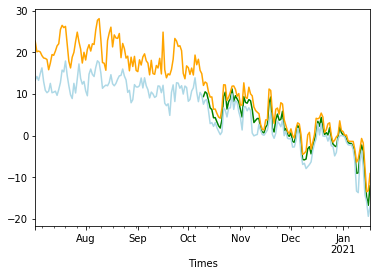

In [46]:
data.Temperature.iloc[-100:].plot(c='green')
data.Temp_min.iloc[-200:].plot(c='lightblue')
data.Temp_max.iloc[-200:].plot(c='orange')

#data.Snowfall_estimate.iloc[-100:].plot(c='green')
#data.Snow_max.iloc[-100:].plot(c='orange')

In [47]:
%%time
# add column called Pseudo_date for easier data grouping and plotting
data['Pseudo_date']=data.apply(lambda row: datetime.datetime(1904,row.name.month,row.name.day,row.name.hour), axis=1)
data['Year']=data.index.year
data['Month']=data.index.month
data['Day']=data.index.day

CPU times: user 440 ms, sys: 9.45 ms, total: 450 ms
Wall time: 505 ms


In [48]:
process = psutil.Process(os.getpid())
print(process.name(),':',process.memory_info().rss/1024/1024,'MB RAM usage')

python3.7 : 167.84375 MB RAM usage


In [49]:
pd.concat([data.head(), data.tail()])

,Temperature,Temp_min,Temp_max,Humidity,Hum_min,Hum_max,Air_pressure,Airp_min,Airp_max,Wind_speed,...,Irrad_max,Gamma_radiation,Gamma_min,Gamma_max,Snowfall_estimate,Snow_max,Pseudo_date,Year,Month,Day
Times,,,,,,,,,,,,,,,,,,,,,
1999-11-01,9.6556,6.5000,12.7000,nan,nan,nan,1004.3181,1001.0000,1007.5000,2.4801,...,nan,0.1042,0.0400,0.1740,0.0000,nan,1904-11-01,1999,11,1
1999-11-02,9.1347,8.2000,10.4000,nan,nan,nan,1003.0531,999.5000,1007.5000,1.5705,...,nan,0.1045,0.0520,0.1850,0.0000,nan,1904-11-02,1999,11,2
1999-11-03,8.9955,6.3000,12.1000,nan,nan,nan,1004.8931,1002.1000,1008.7000,2.9028,...,nan,0.1056,0.0600,0.1820,0.0000,nan,1904-11-03,1999,11,3
1999-11-04,7.1645,3.8000,13.3000,nan,nan,nan,1015.3734,1008.7000,1018.9000,1.4206,...,nan,0.1064,0.0000,0.1650,0.0000,nan,1904-11-04,1999,11,4
1999-11-05,9.8292,8.5000,10.7000,nan,nan,nan,1016.7885,1014.4000,1018.5000,1.1219,...,nan,0.1069,0.0530,0.1770,0.0000,nan,1904-11-05,1999,11,5
2021-01-13,-3.6614,-7.7811,-1.7924,91.0408,87.3036,94.9476,1008.1786,1004.6624,1012.2304,5.2014,...,28.5888,nan,nan,nan,3.7000,0.8000,1904-01-13,2021,1,13
2021-01-14,-10.5062,-14.2779,-7.6962,85.3527,74.8068,90.3599,1013.9790,1012.2595,1015.1126,3.7985,...,93.5853,nan,nan,nan,2.5000,1.3000,1904-01-14,2021,1,14
2021-01-15,-14.7568,-15.8993,-13.5112,84.3357,73.9746,87.6500,1014.9404,1014.3206,1015.5747,1.8198,...,189.3261,nan,nan,nan,0.0000,0.0000,1904-01-15,2021,1,15
2021-01-16,-16.7605,-19.4090,-13.2407,82.1775,73.1517,87.7586,1015.9292,1013.2564,1018.2780,2.2079,...,181.8335,nan,nan,nan,0.0000,0.0000,1904-01-16,2021,1,16


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7749 entries, 1999-11-01 to 2021-01-17
Freq: D
Data columns (total 32 columns):
Temperature          7634 non-null float64
Temp_min             7634 non-null float64
Temp_max             7634 non-null float64
Humidity             7369 non-null float64
Hum_min              7369 non-null float64
Hum_max              7369 non-null float64
Air_pressure         7441 non-null float64
Airp_min             7441 non-null float64
Airp_max             7441 non-null float64
Wind_speed           6209 non-null float64
Winds_min            6209 non-null float64
Winds_max            6209 non-null float64
Wind_direction       6204 non-null float64
Precipitation        7749 non-null float64
Prec_max             6681 non-null float64
UV_index             1005 non-null float64
UV_max               1005 non-null float64
Light                4826 non-null float64
Light_min            4826 non-null float64
Light_max            4826 non-null float64
Irradia

# Perfect time for vacation
Criterias:
1. Highest temperature for the period (mean)
***
2. Lowest amount of rain (sum)
3. Lowest wind speed (mean)

In [51]:
# setting the vacation length in full days
periood=14

 peaks lõikuma Aeg veeru järgi df'i 14-päevasteks lõikudeks ja sealt võtma vajaliku statistika
 kasulik: https://chrisalbon.com/python/data_wrangling/pandas_time_series_basics/ 

 võtame uueks index'iks Aeg tulba ja kustutame eraldi Aeg tulba
<br>
data.index=data['Aeg']
<br>
del data['Aeg']

In [52]:
# loome uue dataframe'i statistika jaoks stat
# peaks tegema nii, et andmeväljadeks oleks 
# 1. Aeg, 
# 2. sellest päeva keskmine temp, 
# 3. päeva sum sademeid, 
# 4. päeva keskmine tuulekiirus


In [53]:
#stat=pd.DataFrame(data[:]['Tuule kiirus'].resample('D').mean())
stat=pd.DataFrame()

In [54]:
#stat.columns=['Keskmine tuule kiirus']

In [55]:
#stat['Keskmine temperatuur']=(data[:]['Temperature'].resample('D').mean())
stat['Keskmine temperatuur']=data['Temperature']

In [56]:
#stat['Sademeid']=data[:]['Sademed'].resample('D').sum()

In [57]:
stat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7749 entries, 1999-11-01 to 2021-01-17
Freq: D
Data columns (total 1 columns):
Keskmine temperatuur    7634 non-null float64
dtypes: float64(1)
memory usage: 121.1 KB


In [58]:
stat.tail(15)

,Keskmine temperatuur
Times,
2021-01-03,-0.7825
2021-01-04,-1.7145
2021-01-05,-1.8830
2021-01-06,-1.9029
2021-01-07,-2.7455
2021-01-08,-4.2459
2021-01-09,-9.0711
2021-01-10,-8.9759
2021-01-11,-4.5812


In [59]:
# loome uue dataframe'i statistika jaoks stat2
# peks tegema nii, et andmeväljadeks oleks 
# 1. Aeg, 
# 2. sellest päevast (kaasa arvatud) perioodi keskmine temp, 
# 3. perioodi sum sademeid, 
# 4. perioodi keskmine tuulekiirus

#stat2=pd.DataFrame()

In [60]:
#lõikan eraldi muutjuasse kõik indexid kuni viimase perioodi alguseni
#eemaldan väärtused
stat2=stat[0:-periood+1].copy()
#stat2['Keskmine tuule kiirus']='NaN'
stat2['Keskmine temperatuur']='NaN'
#stat2['Sademeid']='NaN'

In [61]:
periood

14

In [62]:
%%time
for paev in stat2.index:
    stat2.loc[paev]['Keskmine temperatuur']=stat[paev:paev+periood]['Keskmine temperatuur'].mean()
    #stat2.loc[paev]['Sademeid']=stat[paev:paev+periood]['Sademeid'].sum()
    #stat2.loc[paev]['Keskmine tuule kiirus']=stat[paev:paev+periood]['Keskmine tuule kiirus'].mean()
    

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  


CPU times: user 6.5 s, sys: 62.8 ms, total: 6.56 s
Wall time: 6.88 s


In [63]:
stat2

,Keskmine temperatuur
Times,
1999-11-01,5.0504
1999-11-02,4.3116
1999-11-03,3.6979
1999-11-04,2.7997
1999-11-05,1.9909
...,...
2020-12-31,-3.4373
2021-01-01,-4.4685
2021-01-02,-5.5959


In [64]:
%%time
for element in stat2.columns:
    print(element)
    stat2[element]=pd.to_numeric(stat2[element],errors='coerce')

Keskmine temperatuur
CPU times: user 2.83 ms, sys: 458 µs, total: 3.29 ms
Wall time: 4.69 ms


In [65]:
stat2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7736 entries, 1999-11-01 to 2021-01-04
Freq: D
Data columns (total 1 columns):
Keskmine temperatuur    7662 non-null float64
dtypes: float64(1)
memory usage: 440.9 KB


In [66]:
stat2.tail()

,Keskmine temperatuur
Times,
2020-12-31,-3.4373
2021-01-01,-4.4685
2021-01-02,-5.5959
2021-01-03,-6.3980
2021-01-04,-6.7991


In [67]:
# is it calculcated correctly?
data.Temperature.tail(periood).mean()==stat2.tail(1)

,Keskmine temperatuur
Times,
2021-01-04,True



Lets find a warmest period for every year from DF stat2

In [68]:
range1 = range(stat2.index.min().year+1, stat2.index.max().year+1)

In [69]:
# vaatame, iga aasta soojeima perioodi alguse kuupäeva
print('Length of vacation:',periood)

for aasta in range1:
    print(aasta, " :",stat2[str(aasta)]['Keskmine temperatuur'].idxmax(),':', round(stat2.loc[stat2[str(aasta)]['Keskmine temperatuur'].idxmax()][0],1))

Length of vacation: 14
2000  : 2000-07-11 00:00:00 : 20.4
2001  : 2001-07-18 00:00:00 : 26.8
2002  : 2002-07-08 00:00:00 : 20.1
2003  : 2003-07-20 00:00:00 : 22.6
2004  : 2004-07-26 00:00:00 : 19.9
2005  : 2005-07-04 00:00:00 : 21.1
2006  : 2006-07-01 00:00:00 : 22.0
2007  : 2007-08-03 00:00:00 : 21.4
2008  : 2008-07-13 00:00:00 : 18.1
2009  : 2009-07-15 00:00:00 : 18.5
2010  : 2010-07-11 00:00:00 : 23.8
2011  : 2011-07-17 00:00:00 : 21.1
2012  : 2012-07-24 00:00:00 : 20.1
2013  : 2013-07-27 00:00:00 : 20.0
2014  : 2014-07-07 00:00:00 : 20.2
2015  : 2015-08-02 00:00:00 : 18.9
2016  : 2016-06-19 00:00:00 : 19.9
2017  : 2017-08-05 00:00:00 : 18.4
2018  : 2018-07-20 00:00:00 : 23.8
2019  : 2019-06-04 00:00:00 : 20.2
2020  : 2020-06-15 00:00:00 : 22.0
2021  : 2021-01-01 00:00:00 : -4.5


In [75]:
#%matplotlib qt
%matplotlib inline

In [76]:
stat3=pd.DataFrame()
puhkuselist=[]

2000 - 2000-07-11 00:00:00
2001 - 2001-07-18 00:00:00
2002 - 2002-07-08 00:00:00
2003 - 2003-07-20 00:00:00
2004 - 2004-07-26 00:00:00
2005 - 2005-07-04 00:00:00
2006 - 2006-07-01 00:00:00
2007 - 2007-08-03 00:00:00
2008 - 2008-07-13 00:00:00
2009 - 2009-07-15 00:00:00
2010 - 2010-07-11 00:00:00
2011 - 2011-07-17 00:00:00
2012 - 2012-07-24 00:00:00
2013 - 2013-07-27 00:00:00
2014 - 2014-07-07 00:00:00
2015 - 2015-08-02 00:00:00
2016 - 2016-06-19 00:00:00
2017 - 2017-08-05 00:00:00
2018 - 2018-07-20 00:00:00
2019 - 2019-06-04 00:00:00
2020 - 2020-06-15 00:00:00
2021 - 2021-01-01 00:00:00


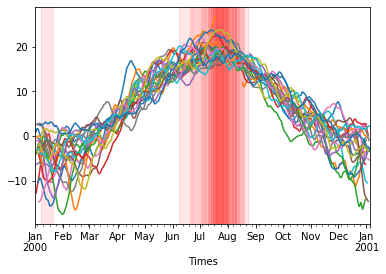

In [77]:
#stat2['2000']['Keskmine temperatuur'].plot(ax=ax)
#stat2['2002']['Keskmine temperatuur'].plot()#(ax=ax)

fig, ax = plt.subplots(1, sharey=True)
nihe=0
for aasta in range1:
#    stat2[str(aasta)]['Keskmine temperatuur'].plot(ax=ax)#.tshift(-365*nihe).plot(ax=ax)
    stat2[str(aasta)]['Keskmine temperatuur'].tshift(-365*nihe).plot(ax=ax)
    puhkus=stat2[str(aasta)].idxmax().tolist()[0]
#    ax.axvspan(puhkus, puhkus+datetime.timedelta(days=periood), color='red', alpha=0.3)
    ax.axvspan(puhkus-datetime.timedelta(days=365*nihe), puhkus+datetime.timedelta(days=periood)-datetime.timedelta(days=365*nihe), color='red', alpha=0.1)
    nihe+=1
    print(aasta, '-', puhkus)
    puhkuselist.append(puhkus)
#    stat2['2001']['Keskmine temperatuur'].tshift(-365).plot(ax=ax)

# Conclusions

...usually it's the <b>second half of july</b> :) 
<br>At least for "standard" length sommer vacations (14 - 21 days)

***
# Other experiments with the dataset...

In [146]:
print(puhkuselist[3].year-2000)
puhkuselist[1]-datetime.timedelta(weeks=52)

3


Timestamp('2000-07-19 00:00:00')

In [147]:
puhkuselist2=[]
for i in range(len(puhkuselist)):
#    print(i)
    puhkuselist2.append(puhkuselist[i]-datetime.timedelta(weeks=52*i))

In [148]:
puhkuselist2

[Timestamp('2000-07-05 00:00:00'),
 Timestamp('2000-07-19 00:00:00'),
 Timestamp('2000-07-14 00:00:00'),
 Timestamp('2000-07-17 00:00:00'),
 Timestamp('2000-07-25 00:00:00'),
 Timestamp('2000-07-08 00:00:00'),
 Timestamp('2000-06-27 00:00:00'),
 Timestamp('2000-08-12 00:00:00'),
 Timestamp('2000-07-22 00:00:00'),
 Timestamp('2000-07-22 00:00:00'),
 Timestamp('2000-07-20 00:00:00'),
 Timestamp('2000-07-21 00:00:00'),
 Timestamp('2000-08-03 00:00:00'),
 Timestamp('2000-07-08 00:00:00'),
 Timestamp('2000-07-24 00:00:00'),
 Timestamp('2000-08-23 00:00:00'),
 Timestamp('2000-07-31 00:00:00'),
 Timestamp('2000-08-20 00:00:00'),
 Timestamp('2000-08-05 00:00:00'),
 Timestamp('2000-06-27 00:00:00'),
 Timestamp('2000-07-03 00:00:00')]

In [149]:
stat3['algus']=puhkuselist
stat3['nihutatud']=puhkuselist2

In [150]:
stat3

,algus,nihutatud
0,2000-07-05,2000-07-05
1,2001-07-18,2000-07-19
2,2002-07-12,2000-07-14
3,2003-07-14,2000-07-17
4,2004-07-20,2000-07-25
5,2005-07-02,2000-07-08
6,2006-06-20,2000-06-27
7,2007-08-04,2000-08-12
8,2008-07-12,2000-07-22
9,2009-07-11,2000-07-22


In [151]:
stat3['nihutatud'].describe()

count                      21
unique                     18
top       2000-07-08 00:00:00
freq                        2
first     2000-06-27 00:00:00
last      2000-08-23 00:00:00
Name: nihutatud, dtype: object

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

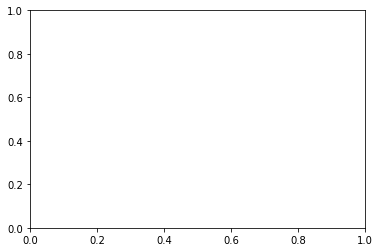

In [152]:
sns.distplot(stat3['nihutatud'])

# Results ver. 1

In [48]:
data.tail()

,Temperature,Temp_min,Temp_max,Humidity,Hum_min,Hum_max,Air_pressure,Airp_min,Airp_max,Wind_speed,...,Irrad_max,Gamma_radiation,Gamma_min,Gamma_max,Snowfall_estimate,Snow_max,Pseudo_date,Year,Month,Day
Times,,,,,,,,,,,,,,,,,,,,,
2021-01-13,-3.6614,-7.7811,-1.7924,91.0408,87.3036,94.9476,1008.1786,1004.6624,1012.2304,5.2014,...,28.5888,nan,nan,nan,3.7000,0.8000,1904-01-13,2021,1,13
2021-01-14,-10.5062,-14.2779,-7.6962,85.3527,74.8068,90.3599,1013.9790,1012.2595,1015.1126,3.7985,...,93.5853,nan,nan,nan,2.5000,1.3000,1904-01-14,2021,1,14
2021-01-15,-14.7568,-15.8993,-13.5112,84.3357,73.9746,87.6500,1014.9404,1014.3206,1015.5747,1.8198,...,189.3261,nan,nan,nan,0.0000,0.0000,1904-01-15,2021,1,15
2021-01-16,-16.7605,-19.4090,-13.2407,82.1775,73.1517,87.7586,1015.9292,1013.2564,1018.2780,2.2079,...,181.8335,nan,nan,nan,0.0000,0.0000,1904-01-16,2021,1,16
2021-01-17,-13.8188,-17.0801,-10.4523,87.3458,84.7852,89.9209,1017.9172,1017.6451,1018.3512,2.1106,...,68.6500,nan,nan,nan,2.0000,2.0000,1904-01-17,2021,1,17


In [64]:
aasta=2019

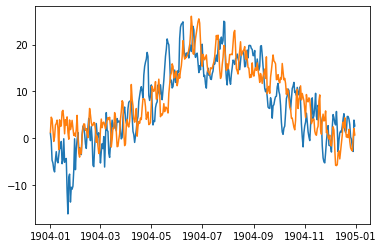

In [65]:
plt.plot(data[data.Year==aasta].Pseudo_date,data[data.Year==aasta].Temperature)
plt.plot(data[data.Year==aasta+1].Pseudo_date,data[data.Year==aasta+1].Temperature)

In [53]:
data[(data.Year==2000)&(data.Month==5)].Temperature.resample('m').mean()

Times
2000-05-31   13.9517
Freq: M, Name: Temperature, dtype: float64

In [54]:
data['2000-05-26 2:00:00':'2000-05-29']

,Temperature,Temp_min,Temp_max,Humidity,Hum_min,Hum_max,Air_pressure,Airp_min,Airp_max,Wind_speed,...,Irrad_max,Gamma_radiation,Gamma_min,Gamma_max,Snowfall_estimate,Snow_max,Pseudo_date,Year,Month,Day
Times,,,,,,,,,,,,,,,,,,,,,
2000-05-27,12.6786,12.1000,13.3000,86.6286,83.5000,89.6000,1010.1429,1009.6000,1010.5000,1.7821,...,0.0000,0.0680,0.0680,0.0680,0.0000,nan,1904-05-27,2000,5,27
2000-05-28,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,0.0000,nan,1904-05-28,2000,5,28
2000-05-29,19.7301,13.5000,28.8000,93.5940,60.4000,100.0000,1001.6241,999.3000,1004.0000,2.3669,...,968.0000,0.1009,0.0630,0.1570,0.0000,nan,1904-05-29,2000,5,29


In [55]:
kriteeria1=(data.Year==2019)&(data.Month==8)
kriteeria2=(data.Year==2020)&(data.Month==8)

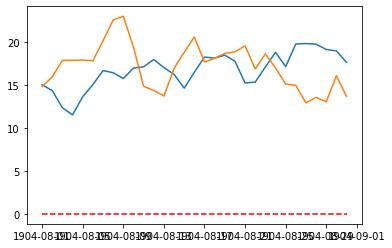

In [56]:
plt.plot(data[kriteeria1].Pseudo_date,data[kriteeria1].Temperature)
plt.plot(data[kriteeria2].Pseudo_date,data[kriteeria2].Temperature)
plt.hlines(0,data[kriteeria1].Pseudo_date[0], data[kriteeria1].Pseudo_date[-1], color='red', linestyles='--')
plt.show()

In [57]:
kriteeria1=(data.Year==2020)&(data.Month==12)
data[kriteeria1].Temperature.resample('m').mean()[0]

-0.6940897122726261

In [58]:
data2=pd.DataFrame()#(index=data[data.Month==12].Year.unique())

In [59]:
data2=[[1999,4]]
pd.concat(data2, pd.DataFrame([[2000,15]]))
#data2['temperatuur'].[2012]=6

TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

In [60]:
data2

[[1999, 4]]

In [61]:
pd.DataFrame([[2000,15]])

,0,1
0,2000,15


In [62]:
data2=pd.DataFrame(index=data[data.Month==12].Year.unique())
for aasta in data[data.Month==12].Year.unique():
    kriteeria1=(data.Year==aasta)&(data.Month==12)
    print(aasta,data[kriteeria1].Temperature.resample('m').mean()[0])
#    if aasta != 2019:
    data2['temperatuur'][aasta]=data[kriteeria1].Temperature.resample('m').mean()[0]
#    plt.plot(data[kriteeria1].Pseudo_date,data[kriteeria1].Temperature)
#    plt.plot(data[kriteeria1].Temperature.resample('m').mean()[0])
#plt.show()

1999 -0.21405428894817652


KeyError: 'temperatuur'

In [63]:
data2

""
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008


## Püüaks need aastad nüüd üksteise peale hihutada koos vspan'idega

In [216]:
puhkus=stat2['2018'].idxmax().tolist()[0]

In [217]:
type(puhkus)

pandas._libs.tslibs.timestamps.Timestamp

In [218]:
puhkus

Timestamp('2018-07-20 00:00:00')

In [219]:
puhkus+datetime.timedelta(days=periood)

Timestamp('2018-08-03 00:00:00')

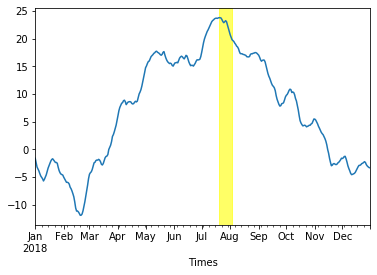

In [220]:
ax=stat2['2018']['Keskmine temperatuur'].plot()
ax.axvspan(puhkus, puhkus+datetime.timedelta(days=periood), color='yellow', alpha=0.6)

In [221]:
print(range(2000,2019))

range(2000, 2019)


In [222]:
stat2['Sademeid'].idxmin()
#df['Value'].idxmax()

KeyError: 'Sademeid'

Kriteeriumid:
1. kõrgeim perioodi temp (keskmine)
2. kõige vähem sademeid (summa)
3. madalaim tuule kiirus? (keskmine)

In [50]:
datetime_object = datetime.strptime('2000', '%Y')

In [51]:
datetime_object

datetime.datetime(2000, 1, 1, 0, 0)

In [52]:
muutuja=pd.Period(2000,'Y')
muutuja

Period('2000', 'A-DEC')

In [53]:
stat2[muutuja]

KeyError: Period('2000', 'A-DEC')

In [199]:
for aasta in range(1999,2018,1):
    print(aasta)
    print(stat2[aasta]['Keskmine temperatuur'].idxmax())

1999


KeyError: 1999

In [210]:
a=stat2['2000']['Keskmine temperatuur'].idxmax()
b=stat2['2000']['Keskmine tuule kiirus'].idxmin()
c=stat2['2000']['Sademeid'].idxmin()

In [211]:
stat2.loc[a]

Keskmine tuule kiirus     2.222083
Keskmine temperatuur     20.378241
Sademeid                  0.000000
Name: 2000-07-11 00:00:00, dtype: float64

In [212]:
stat2.loc[b]

Keskmine tuule kiirus     1.033634
Keskmine temperatuur     11.357500
Sademeid                  0.000000
Name: 2000-09-14 00:00:00, dtype: float64

In [213]:
stat2.loc[c]

Keskmine tuule kiirus    1.683981
Keskmine temperatuur     0.731088
Sademeid                 0.000000
Name: 2000-01-01 00:00:00, dtype: float64

In [223]:
print(stat2['1999']['Keskmine temperatuur'].idxmax())
print(stat2['2000']['Keskmine temperatuur'].idxmax())
print(stat2['2001']['Keskmine temperatuur'].idxmax())
print(stat2['2002']['Keskmine temperatuur'].idxmax())
print(stat2['2003']['Keskmine temperatuur'].idxmax())
print(stat2['2004']['Keskmine temperatuur'].idxmax())
print(stat2['2005']['Keskmine temperatuur'].idxmax())
print(stat2['2006']['Keskmine temperatuur'].idxmax())
print(stat2['2007']['Keskmine temperatuur'].idxmax())
print(stat2['2008']['Keskmine temperatuur'].idxmax())
print(stat2['2009']['Keskmine temperatuur'].idxmax())
print(stat2['2010']['Keskmine temperatuur'].idxmax())
print(stat2['2011']['Keskmine temperatuur'].idxmax())
print(stat2['2012']['Keskmine temperatuur'].idxmax())
print(stat2['2013']['Keskmine temperatuur'].idxmax())
print(stat2['2014']['Keskmine temperatuur'].idxmax())
print(stat2['2015']['Keskmine temperatuur'].idxmax())
print(stat2['2016']['Keskmine temperatuur'].idxmax())
print(stat2['2017']['Keskmine temperatuur'].idxmax())
print(stat2['2018']['Keskmine temperatuur'].idxmax())

1999-11-01 00:00:00
2000-07-11 00:00:00
2001-07-18 00:00:00
2002-07-08 00:00:00
2003-07-20 00:00:00
2004-07-26 00:00:00
2005-07-04 00:00:00
2006-07-01 00:00:00
2007-08-03 00:00:00
2008-07-13 00:00:00
2009-07-15 00:00:00
2010-07-11 00:00:00
2011-07-17 00:00:00
2012-07-24 00:00:00
2013-07-27 00:00:00
2014-07-07 00:00:00
2015-08-02 00:00:00
2016-06-19 00:00:00
2017-08-05 00:00:00
2018-07-20 00:00:00


# future ideas...
1. getting data from PlanetOS datasources?

# Some tests...

In [100]:
%matplotlib qt
# kuvab matplotlib graafikud eraldi aknas

In [73]:
%matplotlib inline
# kuvab graafikud töölehel

In [74]:
data['2008']

,Temperature,Pseudo_date,Year,Month,Day
Times,,,,,
2008-01-01 00:00:00,-2.1984,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:05:00,-2.1992,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:10:00,-2.1769,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:15:00,-2.2000,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:20:00,-2.2000,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:25:00,-2.1968,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:30:00,-2.1931,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:35:00,-2.2000,1904-01-01 00:00:00,2008,1,1
2008-01-01 00:40:00,-2.1089,1904-01-01 00:00:00,2008,1,1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a259b0f28>,
      dtype=object)

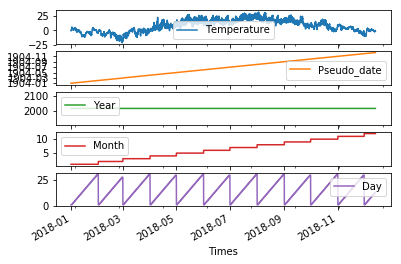

In [75]:
data['2018'].plot(subplots=True)


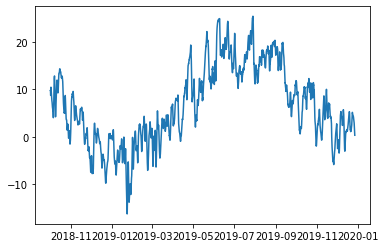

In [122]:
plt.plot(data['2018-10':].Temperature.resample('H').mean().rolling('1D').mean())

In [81]:
data['Pseudo_date']=data.apply(lambda row: datetime.datetime(1904,row.name.month,row.name.day,row.name.hour), axis=1)

In [125]:
data['2017-02-28 20:10:00'].Pseudo_date

Times
2017-02-28 20:10:00   1904-02-28 20:00:00
Name: Pseudo_date, dtype: datetime64[ns]

In [81]:
graafikud=data['2017']
graafikud=graafikud.rename(columns={'Temperature':'2017'})
graafikud.drop(graafikud.columns[1:], axis=1, inplace=True)
graafikud=graafikud.resample('H').mean()

graafikud['Pseudo_date']=graafikud.apply(lambda row: datetime.datetime(1904,row.name.month,row.name.day,row.name.hour), axis=1)
graafikud=graafikud.set_index('Pseudo_date')

In [82]:
graafikud=data['2017']
graafikud=graafikud.rename(columns={'Temperature':'2017'})
graafikud.drop(graafikud.columns[1:], axis=1, inplace=True)
graafikud=graafikud.resample('H').mean()

graafikud['Pseudo_date']=graafikud.apply(lambda row: datetime.datetime(1904,row.name.month,row.name.day,row.name.hour), axis=1)
graafikud=graafikud.set_index('Pseudo_date')

graafikud2=data['2018']
graafikud2=graafikud2.rename(columns={'Temperature':'2018'})
graafikud2.drop(graafikud2.columns[1:], axis=1, inplace=True)
graafikud2=graafikud2.resample('H').mean()
graafikud2['Pseudo_date']=graafikud2.apply(lambda row: datetime.datetime(1904,row.name.month,row.name.day,row.name.hour), axis=1)
graafikud2=graafikud2.set_index('Pseudo_date')

graafikud3=data['2016']
graafikud3=graafikud3.rename(columns={'Temperature':'2016'})
graafikud3.drop(graafikud3.columns[1:], axis=1, inplace=True)
graafikud3=graafikud3.resample('H').mean()
graafikud3['Pseudo_date']=graafikud3.apply(lambda row: datetime.datetime(1904,row.name.month,row.name.day,row.name.hour), axis=1)
graafikud3=graafikud3.set_index('Pseudo_date')

graafikud=pd.concat([graafikud,graafikud2,graafikud3], axis=1)

In [126]:
graafikud.head(15)

NameError: name 'graafikud' is not defined

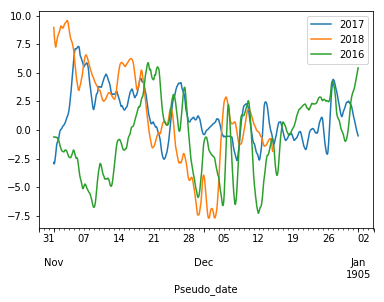

In [88]:

graafikud['1904-11':].rolling('1D').mean().plot()

In [89]:
graafikud.Temperature.rolling('7D').mean().plot()

AttributeError: 'DataFrame' object has no attribute 'Temperature'

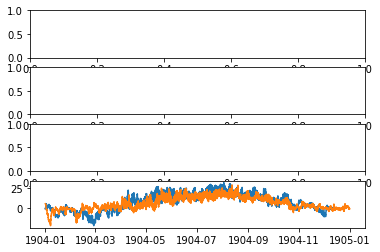

In [90]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
ax2=plt.plot(data['2018'].Pseudo_date, data['2018'].Temperature)
ax0=plt.plot(data['2017'].Pseudo_date, data['2017'].Temperature)
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a24b63d30>,
      dtype=object)

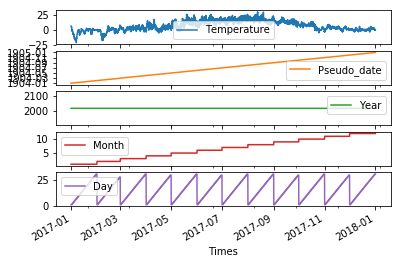

In [91]:
data['2017'].plot(subplots=True)

In [92]:
data['2018'].index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:05:00',
               '2018-01-01 00:10:00', '2018-01-01 00:15:00',
               '2018-01-01 00:20:00', '2018-01-01 00:25:00',
               '2018-01-01 00:30:00', '2018-01-01 00:35:00',
               '2018-01-01 00:40:00', '2018-01-01 00:45:00',
               ...
               '2018-12-13 20:25:00', '2018-12-13 20:30:00',
               '2018-12-13 20:35:00', '2018-12-13 20:40:00',
               '2018-12-13 20:45:00', '2018-12-13 20:50:00',
               '2018-12-13 20:55:00', '2018-12-13 21:00:00',
               '2018-12-13 21:05:00', '2018-12-13 21:10:00'],
              dtype='datetime64[ns]', name='Times', length=100723, freq=None)

viide: https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html

In [93]:
#plt.figure(figsize=(12,5))
fig, ax = plt.subplots(1, sharey=True)
data['2017'].plot(ax=ax)
data['2018'].asfreq('5min').tshift(-60/5*24*365).plot(ax=ax)

#plt.plot(data['2018'].index,data['2018'])

ValueError: view limit minimum -34793.82541004417 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x120c17f28> (for post_execute):


ValueError: view limit minimum -34793.82541004417 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -34793.82541004417 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [75]:
#data=data.asfreq('5min')
data=data.asfreq('1W')

ValueError: cannot reindex from a duplicate axis

In [127]:
data.head(10)

,Temperature,Pseudo_date,Year,Month,Day
Times,,,,,
1999-11-01 00:00:00,6.6000,1904-11-01,1999,11,1
1999-11-01 00:05:00,6.6000,1904-11-01,1999,11,1
1999-11-01 00:10:00,6.5000,1904-11-01,1999,11,1
1999-11-01 00:15:00,6.6000,1904-11-01,1999,11,1
1999-11-01 00:20:00,6.6000,1904-11-01,1999,11,1
1999-11-01 00:25:00,6.7000,1904-11-01,1999,11,1
1999-11-01 00:30:00,6.7000,1904-11-01,1999,11,1
1999-11-01 00:35:00,6.7000,1904-11-01,1999,11,1
1999-11-01 00:40:00,6.7000,1904-11-01,1999,11,1


In [133]:
#plt.show()

***
### Proovime võtteid Datacamp-kursusest Importing and Managing Financial Data in Python
ch3.pdf

In [95]:
%%time
data=pd.read_pickle("data.pkl")
#data.drop(data.columns[1:], axis=1, inplace=True)

CPU times: user 116 ms, sys: 504 ms, total: 619 ms
Wall time: 950 ms


%%time
#### add column called Pseudo_date for easier data grouping and plotting
data['Pseudo_date']=data.apply(lambda row: datetime.datetime(1904,row.name.month,row.name.day), axis=1)
data['Year']=data.index.year
data['Month']=data.index.month
data['Day']=data.index.day

In [96]:
data.head()

,Temperature,Humidity,Air_pressure,Wind_speed,Wind_direction,Precipitation,UV_index,Light,Irradiation_flux,Gamma_radiation,Snowfall_estimate
Times,,,,,,,,,,,
1999-11-01 00:00:00,6.6000,nan,1001.7000,1.1000,227.0000,nan,nan,0.0000,nan,0.0920,nan
1999-11-01 00:05:00,6.6000,nan,1001.5000,1.2000,230.0000,nan,nan,0.0000,nan,0.0900,nan
1999-11-01 00:10:00,6.5000,nan,1001.2000,0.5000,203.0000,nan,nan,0.0000,nan,0.1030,nan
1999-11-01 00:15:00,6.6000,nan,1001.6000,0.8000,223.0000,nan,nan,0.0000,nan,0.0630,nan
1999-11-01 00:20:00,6.6000,nan,1001.7000,1.3000,243.0000,nan,nan,0.0000,nan,0.1010,nan


In [97]:
data[data.index==data.Temperature.idxmax()]

,Temperature,Humidity,Air_pressure,Wind_speed,Wind_direction,Precipitation,UV_index,Light,Irradiation_flux,Gamma_radiation,Snowfall_estimate
Times,,,,,,,,,,,
2001-07-16 13:20:00,33.7000,73.9000,1004.9000,1.8000,243.0000,nan,nan,33250.0000,383.0000,0.1250,nan


In [80]:
data.Temperature.mean()

6.633690660112848

In [81]:
data.Temperature.median()

6.327346551957129

In [82]:
data.Temperature.mode()

0   0.0000
dtype: float64

In [83]:
data.Temperature.var()

90.04879958018567

In [84]:
data.Temperature.std()

9.48940459566277

In [85]:
np.sqrt(data.Temperature.var())==data.Temperature.std()

True

Quantiles: 
* Quartiles (4 groups, each 25% of data) 
* Deciles (10 groups, each 10% of data)
* Interquartile range


In [86]:
data.quantile(.5) #==data.median()

Temperature            6.3273
Humidity              83.3228
Air_pressure        1007.6194
Wind_speed             2.4403
Wind_direction       202.7875
Precipitation          0.0000
UV_index               0.6271
Light               1965.4513
Irradiation_flux       5.5060
Gamma_radiation        0.0967
Snowfall_estimate      0.0000
Name: 0.5, dtype: float64

In [87]:
deciles=np.arange(start=0.1, stop=0.91, step=0.1)
deciles

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [88]:
data.Temperature.quantile(deciles)

0.1000   -5.1412
0.2000   -1.0000
0.3000    1.0776
0.4000    3.4155
0.5000    6.3273
0.6000    9.7000
0.7000   12.7314
0.8000   15.5000
0.9000   18.8310
Name: Temperature, dtype: float64

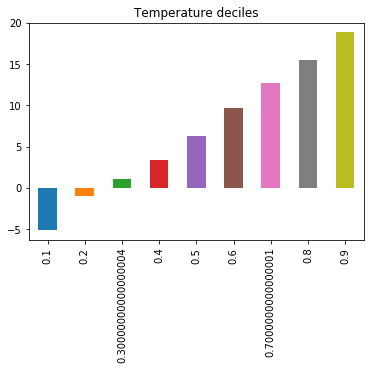

In [89]:
data.Temperature.quantile(deciles).plot(kind='bar',title='Temperature deciles')
#plt.tight_layout()

In [90]:
data.Temperature.describe()

count   1955052.0000
mean          6.6337
std           9.4894
min        -131.8409
25%           0.1183
50%           6.3273
75%          14.1000
max          33.7000
Name: Temperature, dtype: float64

In [91]:
data.Temperature.describe(percentiles=np.arange(0.1,0.91,0.1))

count   1955052.0000
mean          6.6337
std           9.4894
min        -131.8409
10%          -5.1412
20%          -1.0000
30.0%         1.0776
40%           3.4155
50%           6.3273
60%           9.7000
70%          12.7314
80%          15.5000
90%          18.8310
max          33.7000
Name: Temperature, dtype: float64

ch3-video3.mp4
seaborn.distplot()
* histogram
* kernel density estimation (KDE)
* Rugplot

.dropna()
.fillna()

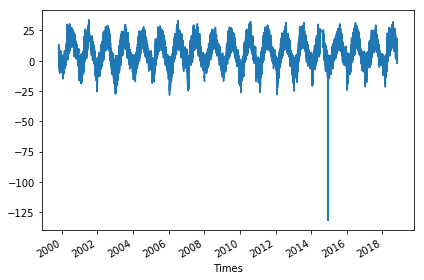

In [92]:
data.Temperature.dropna(inplace=True)
data.Temperature.plot(); plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


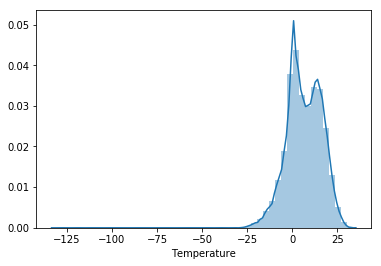

In [93]:
sns.distplot(data.Temperature)

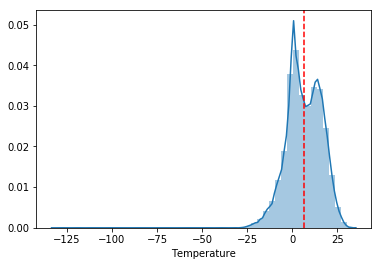

In [94]:
ax=sns.distplot(data.Temperature)
ax.axvline(data.Temperature.median(),color='red',ls='--')

ch3-video4.mp4 "Summarize categorical variables"
<br>quantitative variables vs categorical variables
<br>Instead of "average" and "median" we use frequency distribution.
<br>Columns with numeric data can also represent categoris. IPO year for instance. Or wind direction?
<br>
<br>pandas .nunique() - returns number of different values
<br>pandas .unique() - returns unique values
<br>
<br>function: .applay() - one column of a time!
<br>anonymouse function data.apply(lambda x: x.nunique()) 
<br>lambda: “anonymous function”, receives each column as argument x
<br>
<br>pandas .value_counts()

In [95]:
data.columns.nunique()

11

In [96]:
#how many unique values there are in each column
data.apply(lambda x: x.nunique())

Temperature          1128900
Humidity             1055561
Air_pressure         1080804
Wind_speed            789176
Wind_direction        789280
Precipitation           2331
UV_index              266190
Light                 617069
Irradiation_flux      318494
Gamma_radiation       777819
Snowfall_estimate        102
dtype: int64

In [97]:
data.Wind_direction.value_counts()


0.0000      4700
229.0000    3039
231.0000    2974
230.0000    2970
151.0000    2942
145.0000    2934
142.0000    2933
152.0000    2913
150.0000    2891
144.0000    2873
143.0000    2865
147.0000    2855
228.0000    2814
149.0000    2798
153.0000    2797
146.0000    2790
148.0000    2786
275.0000    2747
257.0000    2747
175.0000    2745
274.0000    2735
154.0000    2729
272.0000    2729
256.0000    2720
232.0000    2717
157.0000    2715
155.0000    2708
273.0000    2698
140.0000    2684
213.0000    2678
            ... 
275.1614       1
313.4934       1
196.5249       1
291.6238       1
246.5553       1
275.9688       1
229.1394       1
220.1717       1
278.4587       1
12.8518        1
252.3731       1
102.6310       1
44.3917        1
280.6343       1
243.6964       1
347.1980       1
278.0902       1
127.9193       1
103.9495       1
292.1775       1
126.1686       1
182.1001       1
243.5219       1
76.1749        1
27.3234        1
40.5878        1
16.1193        1
100.2013      

In [98]:
#how many measurements per year
data.index.year.value_counts()


2016    105398
2004    105387
2012    105174
2017    105121
2005    105100
2009    105081
2008    105057
2013    105043
2006    105003
2010    104942
2007    104906
2011    104874
2015    104695
2003    104678
2002    104264
2000    100137
2001     90905
2014     87607
2018     87025
1999     17461
Name: Times, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

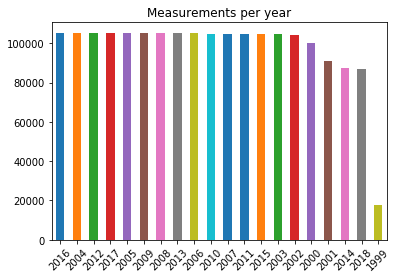

In [99]:
data.index.year.value_counts().plot(kind='bar', title='Measurements per year')
plt.xticks(rotation=45)

Ch4-video1.mp4 "Aggregate your data by category"

describing individual variables -> split data into groups and describe group statistics


In [100]:
data['Year']=data.index.year
data['Month']=data.index.month
data['Day']=data.index.day

In [101]:
data2=data.groupby('Year')

In [102]:
for year, data3 in data2:
    print(year, data3.Temperature.max())

1999 13.3
2000 30.5
2001 33.7
2002 29.3
2003 29.9
2004 28.1
2005 28.8
2006 33.3
2007 30.577327935222698
2008 27.3999999999999
2009 27.731679521634398
2010 32.4742844095636
2011 29.382056234551396
2012 31.727498785801398
2013 31.6163530844
2014 30.1496337649
2015 30.4612893983
2016 31.3848295455
2017 29.3503428571
2018 32.1910773481


In [103]:
data2.Temperature.max()

Year
1999   13.3000
2000   30.5000
2001   33.7000
2002   29.3000
2003   29.9000
2004   28.1000
2005   28.8000
2006   33.3000
2007   30.5773
2008   27.4000
2009   27.7317
2010   32.4743
2011   29.3821
2012   31.7275
2013   31.6164
2014   30.1496
2015   30.4613
2016   31.3848
2017   29.3503
2018   32.1911
Name: Temperature, dtype: float64

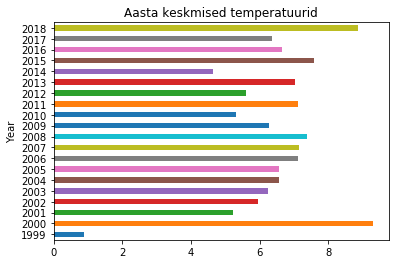

In [104]:
data2.Temperature.mean().plot(kind='barh', title='Aasta keskmised temperatuurid')

In [105]:
data2.mean()

,Temperature,Humidity,Air_pressure,Wind_speed,Wind_direction,Precipitation,UV_index,Light,Irradiation_flux,Gamma_radiation,Snowfall_estimate,Month,Day
Year,,,,,,,,,,,,,
1999,0.8946,nan,1003.8259,1.9810,196.5993,nan,nan,2370.1962,nan,0.1058,nan,11.5113,15.6763
2000,9.2922,87.3727,1007.5969,1.9778,195.1023,nan,nan,11140.0373,146.7000,0.1034,nan,6.4725,15.8583
2001,5.2268,81.0598,1003.6528,2.0567,195.4264,nan,nan,10528.3720,119.7762,0.1022,nan,6.3576,15.4682
2002,5.9598,70.4251,1002.9049,2.2442,183.2559,0.0027,nan,14809.2346,108.9409,0.0994,0.0106,6.4894,15.7398
2003,6.2543,76.9286,1005.2562,1.9590,194.6778,0.0044,nan,11030.6172,106.4701,0.1003,0.0039,6.5348,15.6894
2004,6.5514,78.1754,1004.8746,1.7645,175.4442,0.0038,nan,9573.3528,135.7080,0.1012,0.0017,6.5139,15.7546
2005,6.5669,77.9725,1006.4988,1.8067,170.2293,0.0039,nan,9471.9896,93.1532,0.1009,0.0013,6.5263,15.7190
2006,7.1175,75.4534,1006.4019,1.9601,167.9575,0.0027,nan,13503.4624,149.6931,0.1011,0.0020,6.5244,15.7249
2007,7.1366,76.0590,1012.1834,3.0981,185.8676,0.0041,0.7568,13508.8459,62.1333,0.0962,0.0031,6.5331,15.7412


ch4 video2.mp4 "More ways to aggregate your data"
In practice you need to group by more than one column


In [106]:
data2.Temperature.agg(['mean', 'min', 'max','std'])

,mean,min,max,std
Year,,,,
1999,0.8946,-10.5000,13.3000,4.7441
2000,9.2922,-16.6000,30.5000,8.6824
2001,5.2268,-25.6000,33.7000,9.9149
2002,5.9598,-24.2000,29.3000,10.0625
2003,6.2543,-27.5000,29.9000,9.5256
2004,6.5514,-17.2000,28.1000,8.7821
2005,6.5669,-18.6000,28.8000,9.5656
2006,7.1175,-28.4000,33.3000,10.3363
2007,7.1366,-24.8000,30.5773,9.5735


In [107]:
data2.Temperature.agg({'Keskmine':'mean','Miinimum':'min', 'Maksimum':'max','Standardhälve':'std'})

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,Keskmine,Miinimum,Maksimum,Standardhälve
Year,,,,
1999,0.8946,-10.5000,13.3000,4.7441
2000,9.2922,-16.6000,30.5000,8.6824
2001,5.2268,-25.6000,33.7000,9.9149
2002,5.9598,-24.2000,29.3000,10.0625
2003,6.2543,-27.5000,29.9000,9.5256
2004,6.5514,-17.2000,28.1000,8.7821
2005,6.5669,-18.6000,28.8000,9.5656
2006,7.1175,-28.4000,33.3000,10.3363
2007,7.1366,-24.8000,30.5773,9.5735


In [108]:
data2.agg({'Temperature':'mean','Precipitation':'sum','Wind_speed':'mean'})

,Temperature,Precipitation,Wind_speed
Year,,,
1999,0.8946,0.0000,1.9810
2000,9.2922,0.0000,1.9778
2001,5.2268,0.0000,2.0567
2002,5.9598,141.6000,2.2442
2003,6.2543,460.0000,1.9590
2004,6.5514,400.6000,1.7645
2005,6.5669,411.6000,1.8067
2006,7.1175,277.2000,1.9601
2007,7.1366,422.6000,3.0981


In [109]:
data3=data.groupby(['Year','Month'])

In [110]:
data3.Temperature.mean()

Year  Month
1999  11       2.0596
      12      -0.2260
2000  1       -1.8331
      2        0.2421
      3        2.0353
      4       12.0113
      5       13.8154
      6       17.7279
      7       19.4261
      8       18.7925
      9       12.8987
      10      11.1244
      11       5.6578
      12       1.7479
2001  1       -1.2493
      2       -4.6090
      3       -1.3450
      4        8.7207
      5       12.0745
      6       16.4857
      7       23.0555
      8       11.9679
      9       11.7402
      10       8.1633
      11      -0.0633
      12      -7.8241
2002  1       -3.1913
      2       -0.5574
      3        0.9738
      4        6.2488
                ...  
2016  5       15.1207
      6       16.5643
      7       18.4259
      8       16.4766
      9       12.9001
      10       4.2085
      11      -0.9316
      12      -0.2734
2017  1       -3.5041
      2       -2.9749
      3        1.4416
      4        3.4338
      5       10.3479
      6       13.950

In [111]:
grouped_temp=data3.Temperature.mean()

In [112]:
grouped_temp.loc[[2000,2012]]

Year  Month
2000  1       -1.8331
      2        0.2421
      3        2.0353
      4       12.0113
      5       13.8154
      6       17.7279
      7       19.4261
      8       18.7925
      9       12.8987
      10      11.1244
      11       5.6578
      12       1.7479
2012  1       -4.8184
      2       -9.9274
      3        0.2451
      4        5.1862
      5       12.3286
      6       14.3522
      7       18.6714
      8       15.5312
      9       12.4114
      10       6.1710
      11       2.9964
      12      -6.2022
Name: Temperature, dtype: float64

ch4 video3.mp4 "Summary statistics by category with seaborn"

Seaborn combineds plotting categorical and numerical cariables
* countplot


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

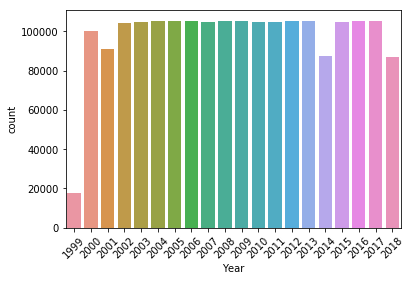

In [113]:
sns.countplot(x='Year', data=data)
plt.xticks(rotation=45)

In [114]:
#sorted list plotting
data2=data.groupby('Year').size()
order=data2.sort_values(ascending=False)
order

Year
2016    105398
2004    105387
2012    105174
2017    105121
2005    105100
2009    105081
2008    105057
2013    105043
2006    105003
2010    104942
2007    104906
2011    104874
2015    104695
2003    104678
2002    104264
2000    100137
2001     90905
2014     87607
2018     87025
1999     17461
dtype: int64

In [115]:
order=order.index.tolist()
order

[2016,
 2004,
 2012,
 2017,
 2005,
 2009,
 2008,
 2013,
 2006,
 2010,
 2007,
 2011,
 2015,
 2003,
 2002,
 2000,
 2001,
 2014,
 2018,
 1999]

Text(0.5, 1.0, '# of measurements per year')

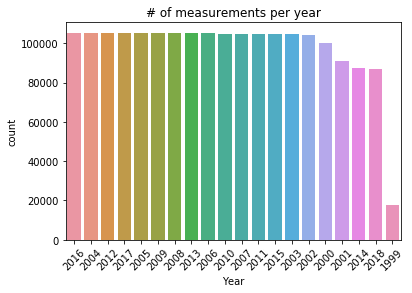

In [116]:
sns.countplot(x='Year', data=data, order=order)
plt.xticks(rotation=45)
plt.title('# of measurements per year')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

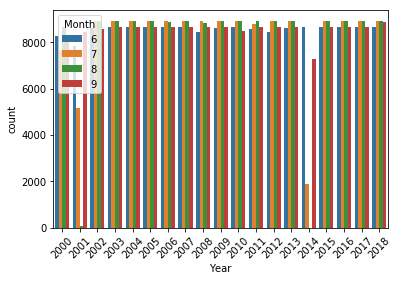

In [117]:
sns.countplot(x='Year', hue='Month', data=data[data['Month'].isin([6,7,8,9])])
plt.xticks(rotation=45)

CPU times: user 21.4 s, sys: 636 ms, total: 22 s
Wall time: 22 s


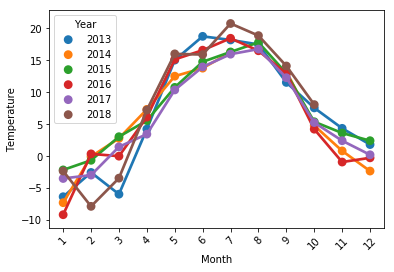

In [118]:
%%time
# Seaborn pointplot
sns.pointplot(x='Month', y='Temperature', hue='Year', data=data[data.Year.isin([2018,2017,2016,2015,2014,2013])])
plt.xticks(rotation=45)

CPU times: user 21 s, sys: 666 ms, total: 21.7 s
Wall time: 21.8 s


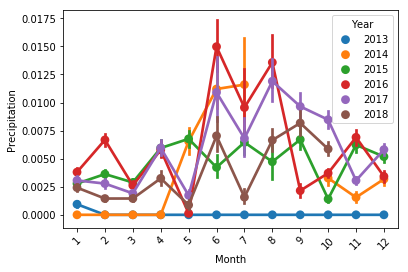

In [125]:
%%time
# Seaborn pointplot
sns.pointplot(x='Month', y='Precipitation', hue='Year', data=data[data.Year.isin([2018,2017,2016,2015,2014,2013])])
plt.xticks(rotation=45)

ch4 video4.mp4 "Distributions by category with seaborn"
visualize distribution of a variable by levels of a categorical variable to facilitate comparison


In [126]:
# remove outliers
outliers_l=data.Temperature.quantile(0.0001)
outliers_h=data.Temperature.quantile(0.995)
print(outliers_l, ';',outliers_h)

-27.0 ; 27.114163795373607


In [127]:
data=data[(data.Temperature > outliers_l)]
#data=data[(data.Temperature < outliers_h)]

In [128]:
len(data)

1954835

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

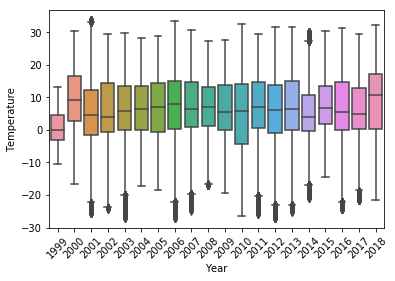

In [129]:
sns.boxplot(x='Year', y='Temperature',data=data)
plt.xticks(rotation=45)

as we have limited number of data for 2018, lets drop 'years-end' datapoints also from other years to get comparable results.
We still have problems with years 2014 and 2001 where some data from sommer months is missing (take a look at countplot graph).


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

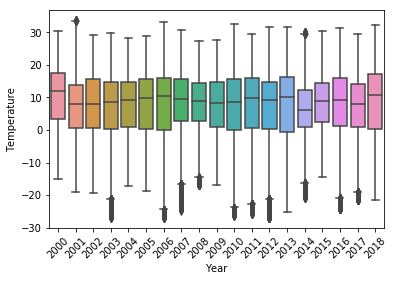

In [132]:
sns.boxplot(x='Year', y='Temperature',data=data[data.Month<11])
plt.xticks(rotation=45)

CPU times: user 8.1 s, sys: 1.07 s, total: 9.17 s
Wall time: 9.58 s


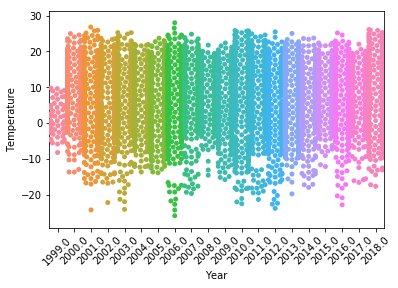

In [133]:
%%time
#SwarmPlot
sns.swarmplot(x='Year',y='Temperature',data=data.resample('D').mean()) #resample to D or W is OK. to H it is to much data still
plt.xticks(rotation=45)

***

***
### Datacamp kursus Manipulating Time Series Data in Python

Chapter11.pdf

In [203]:
%%time
data=pd.read_pickle("data.pkl")
#data.drop(data.columns[1:], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1951797 entries, 1999-11-01 00:00:00 to 2018-10-08 07:50:00
Data columns (total 11 columns):
Temperature          float64
Humidity             float64
Air_pressure         float64
Wind_speed           float64
Wind_direction       float64
Precipitation        float64
UV_index             float64
Light                float64
Irradiation_flux     float64
Gamma_radiation      float64
Snowfall_estimate    float64
dtypes: float64(11)
memory usage: 178.7 MB
Wall time: 220 ms


In [532]:
index=pd.date_range('2018-1-1','2018-12-31',freq='W')
index

DatetimeIndex(['2018-01-07', '2018-01-14', '2018-01-21', '2018-01-28',
               '2018-02-04', '2018-02-11', '2018-02-18', '2018-02-25',
               '2018-03-04', '2018-03-11', '2018-03-18', '2018-03-25',
               '2018-04-01', '2018-04-08', '2018-04-15', '2018-04-22',
               '2018-04-29', '2018-05-06', '2018-05-13', '2018-05-20',
               '2018-05-27', '2018-06-03', '2018-06-10', '2018-06-17',
               '2018-06-24', '2018-07-01', '2018-07-08', '2018-07-15',
               '2018-07-22', '2018-07-29', '2018-08-05', '2018-08-12',
               '2018-08-19', '2018-08-26', '2018-09-02', '2018-09-09',
               '2018-09-16', '2018-09-23', '2018-09-30', '2018-10-07',
               '2018-10-14', '2018-10-21', '2018-10-28', '2018-11-04',
               '2018-11-11', '2018-11-18', '2018-11-25', '2018-12-02',
               '2018-12-09', '2018-12-16', '2018-12-23', '2018-12-30'],
              dtype='datetime64[ns]', freq='W-SUN')

In [533]:
pd.DataFrame({'data':index}).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 1 columns):
data    52 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 496.0 bytes


<hr>

# Juhanile kuu keskmised temperatuurid

In [224]:
juh=pd.DataFrame(data['2018-10'].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'}),columns=['2018-okt'])
juh['2018-nov']=data['2018-11'].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'})
juh['2018-dets']=data['2018-12'].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'})
juh['2019-jan']=data['2019-1'].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'})
juh['2019-feb']=data['2019-2'].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'})
juh['2019-mar']=data['2019-3'].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'})
juh['2019-apr']=data['2019-4'].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'})
#-
juh['2017-okt']=data['2017-10'].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'})
juh['2017-nov']=data['2017-11'].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'})
juh['2017-dets']=data['2017-12'].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'})
juh['2018-jan']=data['2018-1'].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'})
juh['2018-feb']=data['2018-2'].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'})
juh['2018-mar']=data['2018-3'].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'})
juh['2018-apr']=data['2018-4'].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'})
juh

,2018-okt,2018-nov,2018-dets,2019-jan,2019-feb,2019-mar,2019-apr,2017-okt,2017-nov,2017-dets,2018-jan,2018-feb,2018-mar,2018-apr
Temperature,7.4354,2.3774,-2.6694,-5.6832,-0.2003,1.2336,8.0755,5.2387,2.4051,0.2004,-2.3373,-7.8664,-3.4462,7.2021
Wind_speed,3.5438,3.1844,2.9664,3.4724,4.4314,4.2825,2.9762,3.2213,3.4457,3.6319,3.4520,2.5645,3.5162,3.6906
Precipitation,55.2810,18.9590,36.8470,35.7750,35.6900,32.8890,2.9790,75.4790,26.0760,51.8180,21.6050,11.6780,12.9410,28.0400


In [225]:
juh.transpose()

,Temperature,Wind_speed,Precipitation
2018-okt,7.4354,3.5438,55.2810
2018-nov,2.3774,3.1844,18.9590
2018-dets,-2.6694,2.9664,36.8470
2019-jan,-5.6832,3.4724,35.7750
2019-feb,-0.2003,4.4314,35.6900
2019-mar,1.2336,4.2825,32.8890
2019-apr,8.0755,2.9762,2.9790
2017-okt,5.2387,3.2213,75.4790
2017-nov,2.4051,3.4457,26.0760
2017-dets,0.2004,3.6319,51.8180


<hr>

In [43]:
list1=['2017-01','2018-01', '2019-01', 
       '2017-02', '2018-02', '2019-02', 
       '2017-03', '2018-03', '2019-03', 
       '2017-04', '2018-04', '2019-04', 
       '2017-05', '2018-05', '2019-05',
      '2017-06', '2018-06','2019-06',
      '2017-07','2018-07','2019-07',
      '2017-08','2018-08','2019-08',
      '2017-09','2018-09','2019-09']


def statline(year_and_month):
    vastus = data[str(year_and_month)].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'}).transpose()
    return vastus
summarylist=pd.DataFrame(columns=('Temperature', 'Wind_speed', 'Precipitation'))

for kuu in list1:
    summarylist.loc[kuu]=statline(kuu)
summarylist

,Temperature,Wind_speed,Precipitation
2017-01,-3.5041,3.6758,27.3510
2018-01,-2.3373,3.4520,21.6050
2019-01,-5.6832,3.4724,35.7750
2017-02,-2.9749,3.6197,22.4120
2018-02,-7.8658,2.5645,11.6780
2019-02,-0.2003,4.4314,35.6900
2017-03,1.4416,3.6643,17.0380
2018-03,-3.4532,3.5142,12.9410
2019-03,1.2295,4.2798,32.8890
2017-04,3.4338,3.5357,51.4750


### Kuvada grafikule kuu keskmised?

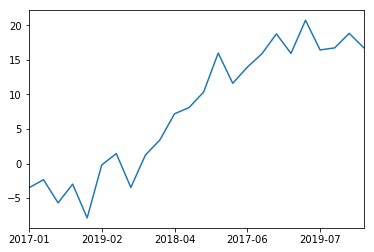

In [31]:
summarylist.Temperature.plot();

In [44]:
kuu

'2019-09'

***

### Käesoleva kuu keskmine temperatuur aastate lõikes

In [226]:
aastad= range(2002,2021)
kuu=[]
praegukuu=str(datetime.datetime.now().month-1)
for i in aastad:
    print(i,round(data[str(i)+'-'+praegukuu].Temperature.mean(),4))
    kuu.append(data[str(i)+'-'+praegukuu].Temperature.mean())
    #print(str(i)+'-08')

#arvutame keskmise üle kõigi aastate
kuukesktemp=np.mean([x for x in kuu if ~np.isnan(x)])
print(datetime.datetime.now().strftime('%B'),'-i aastate keskmine kuu temp.',round(kuukesktemp,4))
ax=plt.bar(aastad,kuu);
plt.hlines(kuukesktemp, color='r', linestyle='--', lw=1, xmin=min(aastad)-1, xmax=max(aastad)+1)
plt.show()


KeyError: '2002-0'

In [50]:
(kuu[-1]-kuukesktemp)/kuukesktemp*100

-18.250901955013216

***

### Aastate keskmine temp

2002 5.9021
2003 6.2819
2004 6.5502
2005 6.5661
2006 7.1219
2007 7.1261
2008 7.4426
2009 6.2861
2010 5.319
2011 7.134
2012 5.6314
2013 7.0423
2014 4.7258
2015 7.5341
2016 6.6585
2017 6.3468
2018 7.2961
2019 7.5528
2020 8.3399
Kogu perioodi aastate keskmine kuu temp. 6.6767


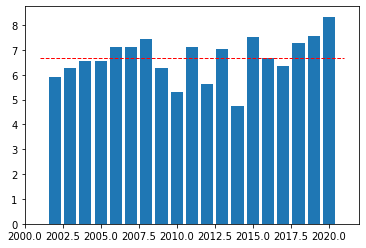

In [230]:
aastad= range(2002,2021)
aastameantemp=[]
#praegukuu=str(datetime.datetime.now().month-1)
for i in aastad:
    print(i,round(data[str(i)].Temperature.mean(),4))
    aastameantemp.append(data[str(i)].Temperature.mean())
    #print(str(i)+'-08')

#arvutame keskmise üle kõigi aastate
aastatemeantemp=np.mean([x for x in aastameantemp if ~np.isnan(x)])
print('Kogu perioodi aastate keskmine kuu temp.',round(aastatemeantemp,4))
ax=plt.bar(aastad,aastameantemp);
plt.hlines(aastatemeantemp, color='r', linestyle='--', lw=1, xmin=min(aastad)-1, xmax=max(aastad)+1)
plt.show()

In [231]:
min(aastad)

2002

In [53]:
data['2019-1'].agg({'Temperature':'mean','Wind_speed':'mean','Precipitation':'sum'})

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6697: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  result, how = self._aggregate(func, axis=axis, *args, **kwargs)


KeyError: 'Wind_speed'

In [44]:
data['2018-12'].Temperature.mean()

-2.703850504225601

In [45]:
data['2018-12'].Precipitation.sum()

36.84699999999998

In [46]:
data['2018-12'].Wind_speed.mean()

2.977824453856367

In [47]:
data['2018-11'].Temperature.mean()

2.392021963348436

In [48]:
data['2018-11'].Precipitation.sum()

18.959

In [49]:
data['2018-11'].Wind_speed.mean()

3.196094290266307

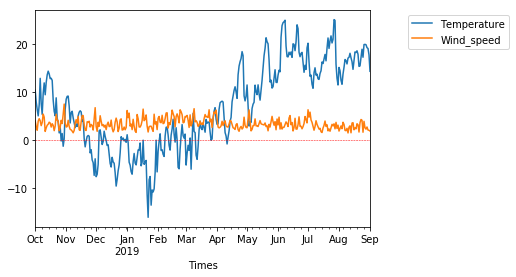

In [38]:
ax=data['2018-10':'2019-12'][['Temperature','Wind_speed']].resample('D').mean().plot();
ax.legend(loc='upper left', bbox_to_anchor=(1.1,1));
#ax=data['2018-10-3']['Temperature'].plot()
#data['2018-10-3']['Precipitation'].dropna().plot(secondary_y='Precipitation', ax=ax)
ax.axhline(y=0, color='r', linestyle='--', linewidth=0.5);

In [36]:
data['2018-12'].mean()

Temperature            -2.701812
Humidity               91.782421
Air_pressure         1014.597500
Wind_speed              2.975866
Wind_direction        161.041612
Precipitation           0.003969
UV_index                     NaN
Light                        NaN
Irradiation_flux        9.070901
Gamma_radiation              NaN
Snowfall_estimate       0.045975
dtype: float64

In [37]:
data['2018-11'].mean()

Temperature             2.377434
Humidity               89.312095
Air_pressure         1024.483117
Wind_speed              3.184963
Wind_direction        212.018508
Precipitation           0.002194
UV_index                     NaN
Light                        NaN
Irradiation_flux       15.006721
Gamma_radiation              NaN
Snowfall_estimate       0.001319
dtype: float64

***